<a href="https://colab.research.google.com/github/aldemirsilva/LPA/blob/main/avd_ativ5_glenn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliação de Desempenho - Atividade 4 (2022-1)

# Atividade e Resolução

## Configuração do Notebook

### Inclusão de Dependências

In [ ]:
# !pip install tqdm scipy statistics matplotlib pandas numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importar Bibliotecas

In [ ]:
from random import random
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
from scipy.stats import t
from statistics import stdev
import matplotlib.pyplot as plt
# import pandas as pd
# from scipy.interpolate import make_interp_spline

### Definição de Classes, Funções e Utilitários

#### Gerador de Variáveis Aleatórias

In [ ]:
def va_exp(beta):
    return -beta * math.log(1 - random())

#### Simulador de Fila M/M/1

In [ ]:
class Simulador_Fila():
    def __init__(self, n, tx_entrada, tx_servico, gerador):
        self.tx_entrada = tx_entrada
        self.tx_servico = tx_servico
        self.gerador = gerador
        self.n = n  #capacidade
        self.n_atual = 0  #ocupação
        # Métricas Fixas
        self.roh = tx_entrada / tx_servico
        self.valor_esperado = self.roh * (1 / tx_servico) / (1 - self.roh)
        self.beta_entrada = 1 / tx_entrada
        self.beta_servico = 1 / tx_servico
        ## Temporários
        self.ultimo_fim_servico_relogio = 0
        self.ultima_chegada_relogio = 0
        ## Séries
        self.serie_tempo_na_fila = np.ndarray(shape=(self.n,), dtype=float)
        ##### Execução inicial
        self.executar()

    def incrementar(self, qntd):
        # Aumentar qntd de observacoes
        self.n += qntd
        self.serie_tempo_na_fila.resize(self.n)
        # Executar
        self.executar()

    def redimensionar(self, novo_n):
        if self.n >= novo_n:
            return
        self.n = novo_n
        self.serie_tempo_na_fila.resize(self.n)
        # Executar
        self.executar()

    def executar(self):
        # Iniciar simulação a partir de onde parou (ou do inicio)
        for i in tqdm(range(self.n_atual, self.n),
                      f'N={self.n} Gerando {self.n - self.n_atual} [{self.n_atual},{self.n - 1}]'):
            tempo_desde_ultima_chegada = self.gerador(self.beta_entrada)
            tempo_do_servico = self.gerador(self.beta_servico)
            tempo_chegada_relogio = self.ultima_chegada_relogio + tempo_desde_ultima_chegada
            tempo_inicio_servico_relogio = max(self.ultimo_fim_servico_relogio, tempo_chegada_relogio)
            self.serie_tempo_na_fila[i] = tempo_inicio_servico_relogio - tempo_chegada_relogio
            tempo_fim_servico_relogio = tempo_inicio_servico_relogio + tempo_do_servico
            #atualizar ultimo
            self.ultimo_fim_servico_relogio = tempo_fim_servico_relogio
            self.ultima_chegada_relogio = tempo_chegada_relogio
        #atualizar n_atual
        self.n_atual = self.n

    def eliminar_transiente(self, ponto):
        self.n -= ponto
        self.n_atual = self.n
        self.serie_tempo_na_fila = np.copy(self.serie_tempo_na_fila[ponto:])

    def media_tempo_na_fila(self):
        return np.mean(self.serie_tempo_na_fila)

    def desvio_padrao_tempo_na_fila(self):
        media = np.mean(self.serie_tempo_na_fila)
        return stdev(self.serie_tempo_na_fila, media)

    def metricas_tempo_na_fila(self, alfa=0.05):
        media = np.mean(self.serie_tempo_na_fila)
        desvio_padrao = stdev(self.serie_tempo_na_fila, media)
        #calcular H
        t_crit = t.ppf(1 - alfa / 2, self.n - 1)
        H = t_crit * desvio_padrao / math.sqrt(self.n)
        return media, H

    def __len__(self):
        return self.n

    def __repr__(self):
        return f"""<Simulador de Fila M/M/1
  - Número de Observações: {self.n}
  - Taxa de Entrada: {self.tx_entrada}/s
  - Taxa de Serviço: {self.tx_servico}/s
  - Última Entrada (Tempo Relógio): {self.ultima_chegada_relogio}
  - Gerador: {self.gerador.__name__}
  >
  """

#### Heurística MSER-5Y

In [ ]:
def mser_5y(fila, M=5):
    obs = fila.serie_tempo_na_fila
    N = fila.n
    K = N // M
    # Calcular Série Z
    serie_Z = np.zeros((K,), dtype=float)
    for j in range(K):
        inicio = j * 5
        serie_Z[j] = np.mean(obs[inicio: inicio + M])
    # Calcular Série MSER5
    serie_MSER5Y = np.zeros((K // 2,), dtype=float)
    for d in tqdm(range(K // 2), "Calcular MSER-5Y(k, d)"):
        zbar = round((1 / (K - d)) * sum(serie_Z, d), 6)
        somatorio = 0
        for j in range(d, K):
            somatorio += (serie_Z[j] - zbar) ** 2
        s2_z = (1 / (K - d)) * somatorio
        serie_MSER5Y[d] = s2_z / math.sqrt(K - d)
    # Salvar Mínimo MSER5 - Ponto de Truncagem
    index_min = min(range(K // 2), key=serie_MSER5Y.__getitem__)
    min_mser = serie_MSER5Y[index_min]
    # Validar Igualdade
    contem_igualdade = False
    for i in tqdm(range(len(serie_MSER5Y) - 1), "Validar MSER5Y-Igualdade Interna"):
        stat_i = round(serie_MSER5Y[i], 6)
        for j in range(i + 1, len(serie_MSER5Y)):
            stat_j = round(serie_MSER5Y[j], 6)
            if stat_i == stat_j:
                return False, -1
    # Validade Segunda Metade (Verificar se há menores)
    for d in tqdm(range(K // 2, K), "Validar MSER5Y-Segunda Metade"):
        zbar = (1 / (K - d)) * sum(serie_Z, d)
        somatorio = 0
        for j in range(d, K):
            somatorio += (serie_Z[j] - zbar) ** 2
        s2_z = (1 / (K - d)) * somatorio
        temp_mser = s2_z / math.sqrt(K - d)
        if temp_mser < min_mser:
            return False, -2
    # Eliminar Transiente
    ponto = (index_min + 1) * M
    # Retornar validade e ponto de truncagem
    return True, ponto


#### Método Batch Means

In [ ]:
class NBM():
    def __init__(self, fila, M, B):
        self.fila = fila
        self.M = M
        self.B = B
        self.serie_NBM = np.zeros((self.B,), dtype=float)
        self.executar()

    def executar(self):
        self.fila.redimensionar(self.M * self.B)
        for i in range(self.B):
            j = i * self.M
            self.serie_NBM[i] = sum(self.fila.serie_tempo_na_fila[j:j + self.M]) / self.M

    def incrementar(self, M):
        self.M += M
        self.executar()

    def metricas(self, alfa=0.05):
        return self.fila.metricas_tempo_na_fila()

    def agrupamento_obm(self, overlap=1):
        overlap = 0 if overlap < 0 else 1 if overlap > 1 else overlap
        self.overlap_qntd = min(math.ceil(overlap * self.M), self.M - 1)
        self.B_linha = int((self.fila.n - self.M) / (self.M - self.overlap_qntd)) + 1
        self.serie_OBM = np.zeros((self.B_linha), dtype=float)
        for i in range(self.B_linha):
            j = i * self.overlap_qntd
            self.serie_OBM[i] = sum(self.fila.serie_tempo_na_fila[j:j + self.M]) / self.M

    def agrupamento_sbm(self, s):
        self.M_linha = self.M - s
        self.serie_SBM = np.zeros((self.B), dtype=float)
        for j in range(self.B):
            for i in range(self.M_linha):
                self.serie_SBM[j] = sum(self.fila.serie_tempo_na_fila[i+j:i + self.M_linha]) / self.M_linha

    def metricas_obm(self, alfa=0.05):
        media = np.mean(self.serie_OBM)
        desvio_padrao = stdev(self.serie_OBM, media)
        # calcular H
        t_crit = t.ppf(1 - alfa / 2, 1.5 * (self.fila.n - 1))
        H = t_crit * desvio_padrao / math.sqrt(self.B_linha)
        return media, H

    def metricas_sbm(self, alfa=0.05):
        media = np.mean(self.serie_SBM)
        desvio_padrao = stdev(self.serie_SBM, media)
        # calcular H
        t_crit = t.ppf(1 - alfa / 2, 1.5 * (self.fila.n - 1))
        H = t_crit * desvio_padrao / math.sqrt(self.B)
        return media, H

    def __len__(self):
        return self.B


#### Teste de von Neuman

In [ ]:
def von_neuman(cenario, valor_critico=1.29):
    blocos = cenario.serie_NBM
    B = len(blocos)
    serie_R = [-1 for _ in range(B)]
    for i, b in enumerate(blocos):
        for tmp in blocos:
            if tmp <= b:
                serie_R[i] += 1
    media_R = sum(serie_R) / B
    RNV = sum([(serie_R[i] - serie_R[i + 1]) ** 2 for i in range(B - 1)]) / sum(
        [(serie_R[i] - media_R) ** 2 for i in range(B)])

    return RNV < valor_critico

#### Plotter

In [ ]:
def plot_graph(results, expected_results, title=""):
    fig, ax = plt.subplots()

    avgs, error_margin = zip(*results)
    colors = ['red', 'blue', 'green', 'brown']
    x = [1, 2, 3, 4]

    for pos, y, err, color, expected in zip(x, avgs, error_margin, colors, expected_results):
        ax.errorbar(pos, y, yerr=err, fmt='o', c=color, mec='black', ms=7, ecolor='black', capsize=5)
        ax.axhline(y=expected, c=color, linestyle='--', label=f'Média esperada C-{pos}')

    plt.xticks([1, 2, 3, 4], ['C-1', 'C-2', 'C-3', 'C-4'])
    plt.margins(0.2)
    plt.ylabel('Tempo médio de espera', fontsize=14)
    plt.xlabel('Cenários', fontsize=14)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(label=title)

    plt.show()

## Atividade 4 – Parte 1
- Executar uma simulação de horizonte infinito da fila M/M/1.
- Eliminar o transiente usando a heurística MSER-5Y.
- Usar o método Batch Means para estimar o tempo médio de espera na fila e o
respectivo intervalo de confiança de 95%.
- A regra de parada é a precisão relativa de 5%.
  - Cenário I: λ=7 clientes por segundo; μ=10 clientes por segundo.
  - Cenário II: λ=8 clientes por segundo; μ=10 clientes por segundo.
  - Cenário III: λ=9 clientes por segundo; μ=10 clientes por segundo.
  - Cenário IV: λ=9,5 clientes por segundo; μ=10 clientes por segundo.
- Plotar um gráfico comparativo dos quatro cenários.
- Plotar uma linha horizontal para o valor teórico esperado em cada cenário.

### Gerar Cenários e Eliminar Transiente

In [ ]:
N = 1000
cenarios = [
    Simulador_Fila(n=N, tx_entrada=7, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=8, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=9, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=9.5, tx_servico=10, gerador=va_exp),
]
for i, c in enumerate(cenarios):
    print(f"Cenário {i + 1}: Entrada {c.tx_entrada} Servico {c.tx_servico}")
    valido, ponto = mser_5y(fila=c, M=5)
    while not valido:
        if ponto == -1:
            print(f"MSER-5Y inválido: Valores iguais encontrados na primeira metade da série.")
        if ponto == -2:
            print(f"MSER-5Y inválido: Estatística menor na segunda metade da série.")
        tmp = c.n
        c.incrementar(c.n)
        print(f'Coletar mais {tmp} observações. Total (n) = {c.n}')
        valido, ponto = mser_5y(fila=c, M=5)
    print(f"MSER-5Y válido: ponto de truncagem={ponto}")
    c.eliminar_transiente(ponto)
    print()

N=1000 Gerando 1000 [0,999]: 100%|██████████| 1000/1000 [00:00<00:00, 250033.03it/s]


Cenário 1: Entrada 7 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 12132.08it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 2: Entrada 8 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 11520.28it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 3: Entrada 9 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 13446.30it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 4: Entrada 9.5 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 16554.07it/s]

MSER-5Y válido: ponto de truncagem=60



### Definir Batch Means e Gerar Observações

In [ ]:
M = 100  #Medias Inicial
B = 20  #Batch Inicial

# N = M*B -> Gerar observações até o necessário
nbm_cenarios = [NBM(c, M, B) for c in cenarios]

N=2000 Gerando 1060 [940,1999]: 100%|██████████| 1060/1060 [00:00<00:00, 308940.47it/s]


### Testar Correlação

In [ ]:
for i, cenario in enumerate(nbm_cenarios):
    tentativa = 1
    while von_neuman(cenario) == False:
        print(f"Teste Von Neuman - Cenário {i + 1}, Tentativa {tentativa}-> N={cenario.fila.n}: Falha")
        cenario.incrementar(100)
        tentativa += 1
    print(f"\nTeste Von Neuman - Cenário {i + 1}, Tentativa {tentativa}-> N={cenario.fila.n}: Sucesso")


Teste Von Neuman - Cenário 1, Tentativa 1-> N=2000: Falha


N=4000 Gerando 2000 [2000,3999]: 100%|██████████| 2000/2000 [00:00<00:00, 314027.18it/s]


Teste Von Neuman - Cenário 1, Tentativa 2-> N=4000: Falha


N=6000 Gerando 2000 [4000,5999]: 100%|██████████| 2000/2000 [00:00<00:00, 304785.38it/s]


Teste Von Neuman - Cenário 1, Tentativa 3-> N=6000: Falha


N=8000 Gerando 2000 [6000,7999]: 100%|██████████| 2000/2000 [00:00<00:00, 197900.54it/s]


Teste Von Neuman - Cenário 1, Tentativa 4-> N=8000: Falha


N=10000 Gerando 2000 [8000,9999]: 100%|██████████| 2000/2000 [00:00<00:00, 189115.77it/s]


Teste Von Neuman - Cenário 1, Tentativa 5-> N=10000: Falha


N=12000 Gerando 2000 [10000,11999]: 100%|██████████| 2000/2000 [00:00<00:00, 159892.65it/s]


Teste Von Neuman - Cenário 1, Tentativa 6-> N=12000: Falha


N=14000 Gerando 2000 [12000,13999]: 100%|██████████| 2000/2000 [00:00<00:00, 323934.51it/s]


Teste Von Neuman - Cenário 1, Tentativa 7-> N=14000: Falha


N=16000 Gerando 2000 [14000,15999]: 100%|██████████| 2000/2000 [00:00<00:00, 329430.10it/s]


Teste Von Neuman - Cenário 1, Tentativa 8-> N=16000: Falha


N=18000 Gerando 2000 [16000,17999]: 100%|██████████| 2000/2000 [00:00<00:00, 328411.23it/s]


Teste Von Neuman - Cenário 1, Tentativa 9-> N=18000: Falha


N=20000 Gerando 2000 [18000,19999]: 100%|██████████| 2000/2000 [00:00<00:00, 250182.17it/s]


Teste Von Neuman - Cenário 1, Tentativa 10-> N=20000: Falha


N=22000 Gerando 2000 [20000,21999]: 100%|██████████| 2000/2000 [00:00<00:00, 210769.05it/s]

Teste Von Neuman - Cenário 1, Tentativa 11-> N=22000: Falha

N=24000 Gerando 2000 [22000,23999]: 100%|██████████| 2000/2000 [00:00<00:00, 214872.13it/s]


Teste Von Neuman - Cenário 1, Tentativa 12-> N=24000: Falha


N=26000 Gerando 2000 [24000,25999]: 100%|██████████| 2000/2000 [00:00<00:00, 234344.84it/s]


Teste Von Neuman - Cenário 1, Tentativa 13-> N=26000: Falha


N=28000 Gerando 2000 [26000,27999]: 100%|██████████| 2000/2000 [00:00<00:00, 338318.53it/s]


Teste Von Neuman - Cenário 1, Tentativa 14-> N=28000: Falha


N=30000 Gerando 2000 [28000,29999]: 100%|██████████| 2000/2000 [00:00<00:00, 267195.67it/s]


Teste Von Neuman - Cenário 1, Tentativa 15-> N=30000: Falha


N=32000 Gerando 2000 [30000,31999]: 100%|██████████| 2000/2000 [00:00<00:00, 279136.43it/s]


Teste Von Neuman - Cenário 1, Tentativa 16-> N=32000: Falha


N=34000 Gerando 2000 [32000,33999]: 100%|██████████| 2000/2000 [00:00<00:00, 264191.48it/s]


Teste Von Neuman - Cenário 1, Tentativa 17-> N=34000: Falha


N=36000 Gerando 2000 [34000,35999]: 100%|██████████| 2000/2000 [00:00<00:00, 187178.86it/s]


Teste Von Neuman - Cenário 1, Tentativa 18-> N=36000: Falha


N=38000 Gerando 2000 [36000,37999]: 100%|██████████| 2000/2000 [00:00<00:00, 281072.47it/s]


Teste Von Neuman - Cenário 1, Tentativa 19-> N=38000: Falha


N=40000 Gerando 2000 [38000,39999]: 100%|██████████| 2000/2000 [00:00<00:00, 288228.70it/s]


Teste Von Neuman - Cenário 1, Tentativa 20-> N=40000: Falha


N=42000 Gerando 2000 [40000,41999]: 100%|██████████| 2000/2000 [00:00<00:00, 276140.89it/s]



Teste Von Neuman - Cenário 1, Tentativa 21-> N=42000: Sucesso
Teste Von Neuman - Cenário 2, Tentativa 1-> N=2000: Falha


N=4000 Gerando 2000 [2000,3999]: 100%|██████████| 2000/2000 [00:00<00:00, 246810.87it/s]


Teste Von Neuman - Cenário 2, Tentativa 2-> N=4000: Falha


N=6000 Gerando 2000 [4000,5999]: 100%|██████████| 2000/2000 [00:00<00:00, 255034.90it/s]


Teste Von Neuman - Cenário 2, Tentativa 3-> N=6000: Falha


N=8000 Gerando 2000 [6000,7999]: 100%|██████████| 2000/2000 [00:00<00:00, 240313.06it/s]


Teste Von Neuman - Cenário 2, Tentativa 4-> N=8000: Falha


N=10000 Gerando 2000 [8000,9999]: 100%|██████████| 2000/2000 [00:00<00:00, 242557.48it/s]

Teste Von Neuman - Cenário 2, Tentativa 5-> N=10000: Falha

N=12000 Gerando 2000 [10000,11999]: 100%|██████████| 2000/2000 [00:00<00:00, 159603.65it/s]

Teste Von Neuman - Cenário 2, Tentativa 6-> N=12000: Falha

N=14000 Gerando 2000 [12000,13999]: 100%|██████████| 2000/2000 [00:00<00:00, 151992.32it/s]


Teste Von Neuman - Cenário 2, Tentativa 7-> N=14000: Falha


N=16000 Gerando 2000 [14000,15999]: 100%|██████████| 2000/2000 [00:00<00:00, 164857.48it/s]


Teste Von Neuman - Cenário 2, Tentativa 8-> N=16000: Falha


N=18000 Gerando 2000 [16000,17999]: 100%|██████████| 2000/2000 [00:00<00:00, 175248.25it/s]


Teste Von Neuman - Cenário 2, Tentativa 9-> N=18000: Falha


N=20000 Gerando 2000 [18000,19999]: 100%|██████████| 2000/2000 [00:00<00:00, 166910.90it/s]


Teste Von Neuman - Cenário 2, Tentativa 10-> N=20000: Falha


N=22000 Gerando 2000 [20000,21999]: 100%|██████████| 2000/2000 [00:00<00:00, 165592.96it/s]


Teste Von Neuman - Cenário 2, Tentativa 11-> N=22000: Falha


N=24000 Gerando 2000 [22000,23999]: 100%|██████████| 2000/2000 [00:00<00:00, 179335.73it/s]


Teste Von Neuman - Cenário 2, Tentativa 12-> N=24000: Falha


N=26000 Gerando 2000 [24000,25999]: 100%|██████████| 2000/2000 [00:00<00:00, 213570.14it/s]


Teste Von Neuman - Cenário 2, Tentativa 13-> N=26000: Falha


N=28000 Gerando 2000 [26000,27999]: 100%|██████████| 2000/2000 [00:00<00:00, 153132.68it/s]


Teste Von Neuman - Cenário 2, Tentativa 14-> N=28000: Falha


N=30000 Gerando 2000 [28000,29999]: 100%|██████████| 2000/2000 [00:00<00:00, 179619.89it/s]



Teste Von Neuman - Cenário 2, Tentativa 15-> N=30000: Sucesso

Teste Von Neuman - Cenário 3, Tentativa 1-> N=2000: Sucesso

Teste Von Neuman - Cenário 4, Tentativa 1-> N=2000: Sucesso


### Estimar o tempo médio de espera na fila e o respectivo intervalo de confiança de 95%

In [ ]:
resultados = []
for i, cenario in enumerate(nbm_cenarios):
    print(f'\nCenário {i + 1}\n')
    media, H = cenario.metricas()
    precisao_relativa = H / media
    while precisao_relativa > 0.05:
        cenario.incrementar(100)
        media, H = cenario.metricas()
        precisao_relativa = H / media
    print(f'\nCenário {i + 1}: Media={media}, H={H}\n')
    resultados.append((media, H))



Cenário 1


Cenário 1: Media=0.22318367351372434, H=0.0028351940803417047


Cenário 2


Cenário 2: Media=0.3706383734663303, H=0.005604983752579502


Cenário 3


Cenário 3: Media=0.6559131885225999, H=0.026338534091549123


Cenário 4


Cenário 4: Media=1.8704222473331407, H=0.060610603022678115



### Plotar Gráfico

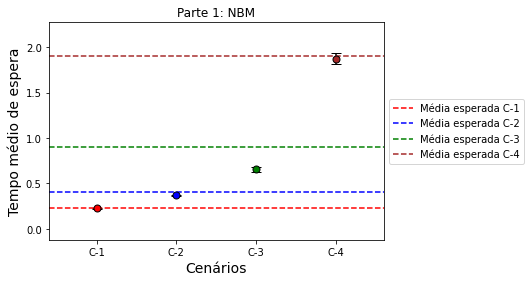

In [ ]:
valores_esperados = [c.fila.valor_esperado for c in nbm_cenarios]
plot_graph(resultados, valores_esperados, "Parte 1: NBM")

## Atividade 4 – Parte 2
- Executar uma simulação de horizonte infinito da fila M/M/1.
- Eliminar o transiente usando a heurística MSER-5Y.
- Usar o método Spaced Batch Means para estimar o tempo médio de
espera na fila e o respectivo intervalo de confiança de 95%.
- Valor de S: 0, 1, 2, 3, 4.
- A regra de parada é a precisão relativa de 5%.
  - Cenário I: λ=7 clientes por segundo; μ=10 clientes por segundo.
  - Cenário II: λ=8 clientes por segundo; μ=10 clientes por segundo.
  - Cenário III: λ=9 clientes por segundo; μ=10 clientes por segundo.
  - Cenário IV: λ=9,5 clientes por segundo; μ=10 clientes por segundo.
- Plotar um gráfico comparativo dos quatro cenários.
- Plotar uma linha horizontal para o valor teórico esperado em cada cenário.

### Gerar Cenários e Eliminar Transiente

In [ ]:
N = 1000
cenarios = [
    Simulador_Fila(n=N, tx_entrada=7, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=8, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=9, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=9.5, tx_servico=10, gerador=va_exp),
]
for i, c in enumerate(cenarios):
    print(f"Cenário {i + 1}: Entrada {c.tx_entrada} Servico {c.tx_servico}")
    valido, ponto = mser_5y(fila=c, M=5)
    while not valido:
        if ponto == -1:
            print(f"MSER-5Y inválido: Valores iguais encontrados na primeira metade da série.")
        if ponto == -2:
            print(f"MSER-5Y inválido: Estatística menor na segunda metade da série.")
        tmp = c.n
        c.incrementar(c.n)
        print(f'Coletar mais {tmp} observações. Total (n) = {c.n}')
        valido, ponto = mser_5y(fila=c, M=5)
    print(f"MSER-5Y válido: ponto de truncagem={ponto}")
    c.eliminar_transiente(ponto)
    print()

N=1000 Gerando 1000 [0,999]: 100%|██████████| 1000/1000 [00:00<00:00, 150895.96it/s]


Cenário 1: Entrada 7 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 10756.83it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 2: Entrada 8 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 6381.11it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 3: Entrada 9 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 6558.52it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 4: Entrada 9.5 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 10341.24it/s]


MSER-5Y válido: ponto de truncagem=5



### Definir Batch Means e Gerar Observações

In [ ]:
M = 100  #Medias Inicial
B = 20  #Batch Inicial

# N = M*B -> Gerar observações até o necessário
sbm_cenarios = [NBM(c, M, B) for c in cenarios]

N=2000 Gerando 1005 [995,1999]: 100%|██████████| 1005/1005 [00:00<00:00, 317750.30it/s]


### Testar Correlação

In [ ]:
for i, cenario in enumerate(sbm_cenarios):
    tentativa = 1
    while von_neuman(cenario) == False:
        print(f"Teste Von Neuman - Cenário {i + 1}, Tentativa {tentativa}-> N={cenario.fila.n}: Falha")
        cenario.incrementar(100)
        tentativa += 1
    print(f"\nTeste Von Neuman - Cenário {i + 1}, Tentativa {tentativa}-> N={cenario.fila.n}: Sucesso")



Teste Von Neuman - Cenário 1, Tentativa 1-> N=2000: Sucesso
Teste Von Neuman - Cenário 2, Tentativa 1-> N=2000: Falha


N=4000 Gerando 2000 [2000,3999]: 100%|██████████| 2000/2000 [00:00<00:00, 316766.41it/s]


Teste Von Neuman - Cenário 2, Tentativa 2-> N=4000: Sucesso

Teste Von Neuman - Cenário 3, Tentativa 1-> N=2000: Sucesso

Teste Von Neuman - Cenário 4, Tentativa 1-> N=2000: Sucesso


### Agrupamento de Blocos para SBM

In [ ]:
resultados = []
for i, cenario in enumerate(obm_cenarios):
    print(f'\nCenário {i + 1}\n')
    cenario.agrupamento_obm()
    media, H = cenario.metricas_obm()
    precisao_relativa = H / media
    while precisao_relativa > 0.05:
        cenario.fila.redimensionar(int((cenario.B_linha * 0.02) * cenario.M))
        cenario.agrupamento_obm()
        media, H = cenario.metricas_obm()
        precisao_relativa = H / media
    print(f'\nCenário {i + 1}: Media={media}, H={H}\n')
    resultados.append((media, H))


Cenário 1



N=461510 Gerando 230656 [230854,461509]: 100%|██████████| 230656/230656 [00:01<00:00, 215354.61it/s]



Cenário 1: Media=0.0023580237321019332, H=8.280331663919914e-05


Cenário 2



N=956340 Gerando 717056 [239284,956339]: 100%|██████████| 717056/717056 [00:03<00:00, 226688.56it/s]



Cenário 2: Media=0.0020133391915533195, H=6.851089319689712e-05


Cenário 3



N=461510 Gerando 230656 [230854,461509]: 100%|██████████| 230656/230656 [00:00<00:00, 281258.47it/s]



Cenário 3: Media=0.009359573019596494, H=0.0003867586649260051


Cenário 4



N=461510 Gerando 230656 [230854,461509]: 100%|██████████| 230656/230656 [00:00<00:00, 580230.76it/s]



Cenário 4: Media=0.01810345678063426, H=0.0007347520245625757



### Plotar Gráfico

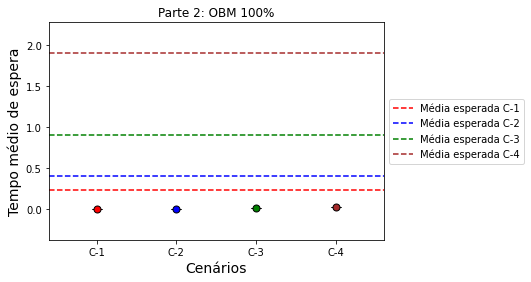

In [ ]:
valores_esperados = [c.fila.valor_esperado for c in obm_cenarios]
plot_graph(resultados, valores_esperados, "Parte 2: OBM 100%")

## Atividade 4 – Parte 3
- Execute uma simulação de horizonte infinito da fila M/M/1.
- Eliminar o transiente usando a heurística MSER-5Y.
- Usar o método Overlapping Batch Means para estimar o tempo médio de
espera na fila e o respectivo intervalo de confiança de 95%.
- A regra de parada é a precisão relativa de 5%.
  - Cenário I: λ=7 clientes por segundo; μ=10 clientes por segundo.
  - Cenário II: λ=8 clientes por segundo; μ=10 clientes por segundo.
  - Cenário III: λ=9 clientes por segundo; μ=10 clientes por segundo.
  - Cenário IV: λ=9,5 clientes por segundo; μ=10 clientes por segundo.
- Plotar um gráfico comparativo dos quatro cenários.
- Plotar uma linha horizontal para o valor teórico esperado em cada cenário.
- Repetir para diferentes graus de superposição (overlap): 10%, 25% e 50%.

### 10%

In [ ]:
N = 1000
cenarios = [
    Simulador_Fila(n=N, tx_entrada=7, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=8, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=9, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=9.5, tx_servico=10, gerador=va_exp),
]
for i, c in enumerate(cenarios):
    print(f"Cenário {i + 1}: Entrada {c.tx_entrada} Servico {c.tx_servico}")
    valido, ponto = mser_5y(fila=c, M=5)
    while not valido:
        if ponto == -1:
            print(f"MSER-5Y inválido: Valores iguais encontrados na primeira metade da série.")
        if ponto == -2:
            print(f"MSER-5Y inválido: Estatística menor na segunda metade da série.")
        tmp = c.n
        c.incrementar(c.n)
        print(f'Coletar mais {tmp} observações. Total (n) = {c.n}')
        valido, ponto = mser_5y(fila=c, M=5)
    print(f"MSER-5Y válido: ponto de truncagem={ponto}")
    c.eliminar_transiente(ponto)
    print()

N=1000 Gerando 1000 [0,999]: 100%|██████████| 1000/1000 [00:00<00:00, 312634.47it/s]


Cenário 1: Entrada 7 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 15148.45it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 2: Entrada 8 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 11796.66it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 3: Entrada 9 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 16030.21it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 4: Entrada 9.5 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 9771.24it/s]

MSER-5Y válido: ponto de truncagem=5



In [ ]:
M = 100  #Medias Inicial
B = 20  #Batch Inicial

# N = M*B -> Gerar observações até o necessário
obm_cenarios = [NBM(c, M, B) for c in cenarios]

N=2000 Gerando 1005 [995,1999]: 100%|██████████| 1005/1005 [00:00<00:00, 345486.07it/s]


In [ ]:
for i, cenario in enumerate(obm_cenarios):
    tentativa = 1
    while von_neuman(cenario) == False:
        print(f"Teste Von Neuman - Cenário {i + 1}, Tentativa {tentativa}-> N={cenario.fila.n}: Falha")
        cenario.incrementar(100)
        tentativa += 1
    print(f"\nTeste Von Neuman - Cenário {i + 1}, Tentativa {tentativa}-> N={cenario.fila.n}: Sucesso")


Teste Von Neuman - Cenário 1, Tentativa 1-> N=2000: Falha


N=4000 Gerando 2000 [2000,3999]: 100%|██████████| 2000/2000 [00:00<00:00, 281515.81it/s]


Teste Von Neuman - Cenário 1, Tentativa 2-> N=4000: Falha


N=6000 Gerando 2000 [4000,5999]: 100%|██████████| 2000/2000 [00:00<00:00, 133008.94it/s]


Teste Von Neuman - Cenário 1, Tentativa 3-> N=6000: Falha


N=8000 Gerando 2000 [6000,7999]: 100%|██████████| 2000/2000 [00:00<00:00, 398300.56it/s]


Teste Von Neuman - Cenário 1, Tentativa 4-> N=8000: Falha


N=10000 Gerando 2000 [8000,9999]: 100%|██████████| 2000/2000 [00:00<00:00, 142663.40it/s]


Teste Von Neuman - Cenário 1, Tentativa 5-> N=10000: Falha


N=12000 Gerando 2000 [10000,11999]: 100%|██████████| 2000/2000 [00:00<00:00, 186712.25it/s]


Teste Von Neuman - Cenário 1, Tentativa 6-> N=12000: Falha


N=14000 Gerando 2000 [12000,13999]: 100%|██████████| 2000/2000 [00:00<00:00, 177172.96it/s]


Teste Von Neuman - Cenário 1, Tentativa 7-> N=14000: Falha


N=16000 Gerando 2000 [14000,15999]: 100%|██████████| 2000/2000 [00:00<00:00, 192575.94it/s]


Teste Von Neuman - Cenário 1, Tentativa 8-> N=16000: Falha


N=18000 Gerando 2000 [16000,17999]: 100%|██████████| 2000/2000 [00:00<00:00, 280705.66it/s]


Teste Von Neuman - Cenário 1, Tentativa 9-> N=18000: Falha


N=20000 Gerando 2000 [18000,19999]: 100%|██████████| 2000/2000 [00:00<00:00, 236358.74it/s]


Teste Von Neuman - Cenário 1, Tentativa 10-> N=20000: Falha


N=22000 Gerando 2000 [20000,21999]: 100%|██████████| 2000/2000 [00:00<00:00, 236952.94it/s]


Teste Von Neuman - Cenário 1, Tentativa 11-> N=22000: Falha


N=24000 Gerando 2000 [22000,23999]: 100%|██████████| 2000/2000 [00:00<00:00, 276322.81it/s]


Teste Von Neuman - Cenário 1, Tentativa 12-> N=24000: Falha


N=26000 Gerando 2000 [24000,25999]: 100%|██████████| 2000/2000 [00:00<00:00, 280555.45it/s]


Teste Von Neuman - Cenário 1, Tentativa 13-> N=26000: Falha


N=28000 Gerando 2000 [26000,27999]: 100%|██████████| 2000/2000 [00:00<00:00, 283054.66it/s]


Teste Von Neuman - Cenário 1, Tentativa 14-> N=28000: Falha


N=30000 Gerando 2000 [28000,29999]: 100%|██████████| 2000/2000 [00:00<00:00, 282787.49it/s]


Teste Von Neuman - Cenário 1, Tentativa 15-> N=30000: Falha


N=32000 Gerando 2000 [30000,31999]: 100%|██████████| 2000/2000 [00:00<00:00, 290152.81it/s]


Teste Von Neuman - Cenário 1, Tentativa 16-> N=32000: Falha


N=34000 Gerando 2000 [32000,33999]: 100%|██████████| 2000/2000 [00:00<00:00, 272110.03it/s]


Teste Von Neuman - Cenário 1, Tentativa 17-> N=34000: Falha


N=36000 Gerando 2000 [34000,35999]: 100%|██████████| 2000/2000 [00:00<00:00, 272516.67it/s]


Teste Von Neuman - Cenário 1, Tentativa 18-> N=36000: Falha


N=38000 Gerando 2000 [36000,37999]: 100%|██████████| 2000/2000 [00:00<00:00, 211278.66it/s]


Teste Von Neuman - Cenário 1, Tentativa 19-> N=38000: Falha


N=40000 Gerando 2000 [38000,39999]: 100%|██████████| 2000/2000 [00:00<00:00, 291453.27it/s]


Teste Von Neuman - Cenário 1, Tentativa 20-> N=40000: Falha


N=42000 Gerando 2000 [40000,41999]: 100%|██████████| 2000/2000 [00:00<00:00, 294688.68it/s]


Teste Von Neuman - Cenário 1, Tentativa 21-> N=42000: Falha


N=44000 Gerando 2000 [42000,43999]: 100%|██████████| 2000/2000 [00:00<00:00, 282368.65it/s]


Teste Von Neuman - Cenário 1, Tentativa 22-> N=44000: Falha


N=46000 Gerando 2000 [44000,45999]: 100%|██████████| 2000/2000 [00:00<00:00, 260896.59it/s]


Teste Von Neuman - Cenário 1, Tentativa 23-> N=46000: Falha


N=48000 Gerando 2000 [46000,47999]: 100%|██████████| 2000/2000 [00:00<00:00, 224360.32it/s]


Teste Von Neuman - Cenário 1, Tentativa 24-> N=48000: Falha


N=50000 Gerando 2000 [48000,49999]: 100%|██████████| 2000/2000 [00:00<00:00, 266864.16it/s]


Teste Von Neuman - Cenário 1, Tentativa 25-> N=50000: Falha


N=52000 Gerando 2000 [50000,51999]: 100%|██████████| 2000/2000 [00:00<00:00, 324372.92it/s]


Teste Von Neuman - Cenário 1, Tentativa 26-> N=52000: Falha


N=54000 Gerando 2000 [52000,53999]: 100%|██████████| 2000/2000 [00:00<00:00, 272738.17it/s]

Teste Von Neuman - Cenário 1, Tentativa 27-> N=54000: Falha

N=56000 Gerando 2000 [54000,55999]: 100%|██████████| 2000/2000 [00:00<00:00, 287320.45it/s]

Teste Von Neuman - Cenário 1, Tentativa 28-> N=56000: Falha

N=58000 Gerando 2000 [56000,57999]: 100%|██████████| 2000/2000 [00:00<00:00, 312552.93it/s]

Teste Von Neuman - Cenário 1, Tentativa 29-> N=58000: Falha

N=60000 Gerando 2000 [58000,59999]: 100%|██████████| 2000/2000 [00:00<00:00, 280668.09it/s]

Teste Von Neuman - Cenário 1, Tentativa 30-> N=60000: Falha

N=62000 Gerando 2000 [60000,61999]: 100%|██████████| 2000/2000 [00:00<00:00, 348523.33it/s]


Teste Von Neuman - Cenário 1, Tentativa 31-> N=62000: Falha


N=64000 Gerando 2000 [62000,63999]: 100%|██████████| 2000/2000 [00:00<00:00, 281704.88it/s]


Teste Von Neuman - Cenário 1, Tentativa 32-> N=64000: Falha


N=66000 Gerando 2000 [64000,65999]: 100%|██████████| 2000/2000 [00:00<00:00, 305429.02it/s]


Teste Von Neuman - Cenário 1, Tentativa 33-> N=66000: Falha


N=68000 Gerando 2000 [66000,67999]: 100%|██████████| 2000/2000 [00:00<00:00, 280677.49it/s]


Teste Von Neuman - Cenário 1, Tentativa 34-> N=68000: Falha


N=70000 Gerando 2000 [68000,69999]: 100%|██████████| 2000/2000 [00:00<00:00, 296910.35it/s]


Teste Von Neuman - Cenário 1, Tentativa 35-> N=70000: Falha


N=72000 Gerando 2000 [70000,71999]: 100%|██████████| 2000/2000 [00:00<00:00, 283792.01it/s]


Teste Von Neuman - Cenário 1, Tentativa 36-> N=72000: Falha


N=74000 Gerando 2000 [72000,73999]: 100%|██████████| 2000/2000 [00:00<00:00, 294130.72it/s]


Teste Von Neuman - Cenário 1, Tentativa 37-> N=74000: Falha


N=76000 Gerando 2000 [74000,75999]: 100%|██████████| 2000/2000 [00:00<00:00, 291666.08it/s]


Teste Von Neuman - Cenário 1, Tentativa 38-> N=76000: Falha


N=78000 Gerando 2000 [76000,77999]: 100%|██████████| 2000/2000 [00:00<00:00, 292980.16it/s]


Teste Von Neuman - Cenário 1, Tentativa 39-> N=78000: Falha


N=80000 Gerando 2000 [78000,79999]: 100%|██████████| 2000/2000 [00:00<00:00, 285910.29it/s]


Teste Von Neuman - Cenário 1, Tentativa 40-> N=80000: Falha


N=82000 Gerando 2000 [80000,81999]: 100%|██████████| 2000/2000 [00:00<00:00, 287556.84it/s]


Teste Von Neuman - Cenário 1, Tentativa 41-> N=82000: Falha


N=84000 Gerando 2000 [82000,83999]: 100%|██████████| 2000/2000 [00:00<00:00, 283427.64it/s]


Teste Von Neuman - Cenário 1, Tentativa 42-> N=84000: Falha


N=86000 Gerando 2000 [84000,85999]: 100%|██████████| 2000/2000 [00:00<00:00, 286888.10it/s]


Teste Von Neuman - Cenário 1, Tentativa 43-> N=86000: Falha


N=88000 Gerando 2000 [86000,87999]: 100%|██████████| 2000/2000 [00:00<00:00, 419661.21it/s]


Teste Von Neuman - Cenário 1, Tentativa 44-> N=88000: Falha


N=90000 Gerando 2000 [88000,89999]: 100%|██████████| 2000/2000 [00:00<00:00, 193683.08it/s]


Teste Von Neuman - Cenário 1, Tentativa 45-> N=90000: Falha


N=92000 Gerando 2000 [90000,91999]: 100%|██████████| 2000/2000 [00:00<00:00, 253325.12it/s]


Teste Von Neuman - Cenário 1, Tentativa 46-> N=92000: Falha


N=94000 Gerando 2000 [92000,93999]: 100%|██████████| 2000/2000 [00:00<00:00, 316898.04it/s]


Teste Von Neuman - Cenário 1, Tentativa 47-> N=94000: Falha


N=96000 Gerando 2000 [94000,95999]: 100%|██████████| 2000/2000 [00:00<00:00, 229403.78it/s]


Teste Von Neuman - Cenário 1, Tentativa 48-> N=96000: Falha


N=98000 Gerando 2000 [96000,97999]: 100%|██████████| 2000/2000 [00:00<00:00, 180051.68it/s]


Teste Von Neuman - Cenário 1, Tentativa 49-> N=98000: Falha


N=100000 Gerando 2000 [98000,99999]: 100%|██████████| 2000/2000 [00:00<00:00, 252836.46it/s]


Teste Von Neuman - Cenário 1, Tentativa 50-> N=100000: Falha


N=102000 Gerando 2000 [100000,101999]: 100%|██████████| 2000/2000 [00:00<00:00, 276131.80it/s]


Teste Von Neuman - Cenário 1, Tentativa 51-> N=102000: Falha


N=104000 Gerando 2000 [102000,103999]: 100%|██████████| 2000/2000 [00:00<00:00, 282045.86it/s]


Teste Von Neuman - Cenário 1, Tentativa 52-> N=104000: Falha


N=106000 Gerando 2000 [104000,105999]: 100%|██████████| 2000/2000 [00:00<00:00, 280978.33it/s]


Teste Von Neuman - Cenário 1, Tentativa 53-> N=106000: Falha


N=108000 Gerando 2000 [106000,107999]: 100%|██████████| 2000/2000 [00:00<00:00, 243204.45it/s]


Teste Von Neuman - Cenário 1, Tentativa 54-> N=108000: Falha


N=110000 Gerando 2000 [108000,109999]: 100%|██████████| 2000/2000 [00:00<00:00, 288834.07it/s]


Teste Von Neuman - Cenário 1, Tentativa 55-> N=110000: Falha


N=112000 Gerando 2000 [110000,111999]: 100%|██████████| 2000/2000 [00:00<00:00, 287507.56it/s]


Teste Von Neuman - Cenário 1, Tentativa 56-> N=112000: Falha


N=114000 Gerando 2000 [112000,113999]: 100%|██████████| 2000/2000 [00:00<00:00, 287054.99it/s]


Teste Von Neuman - Cenário 1, Tentativa 57-> N=114000: Falha


N=116000 Gerando 2000 [114000,115999]: 100%|██████████| 2000/2000 [00:00<00:00, 363033.19it/s]


Teste Von Neuman - Cenário 1, Tentativa 58-> N=116000: Falha


N=118000 Gerando 2000 [116000,117999]: 100%|██████████| 2000/2000 [00:00<00:00, 324938.33it/s]


Teste Von Neuman - Cenário 1, Tentativa 59-> N=118000: Falha


N=120000 Gerando 2000 [118000,119999]: 100%|██████████| 2000/2000 [00:00<00:00, 407332.62it/s]


Teste Von Neuman - Cenário 1, Tentativa 60-> N=120000: Falha


N=122000 Gerando 2000 [120000,121999]: 100%|██████████| 2000/2000 [00:00<00:00, 284195.82it/s]


Teste Von Neuman - Cenário 1, Tentativa 61-> N=122000: Falha


N=124000 Gerando 2000 [122000,123999]: 100%|██████████| 2000/2000 [00:00<00:00, 402119.17it/s]


Teste Von Neuman - Cenário 1, Tentativa 62-> N=124000: Falha


N=126000 Gerando 2000 [124000,125999]: 100%|██████████| 2000/2000 [00:00<00:00, 258739.95it/s]


Teste Von Neuman - Cenário 1, Tentativa 63-> N=126000: Falha


N=128000 Gerando 2000 [126000,127999]: 100%|██████████| 2000/2000 [00:00<00:00, 265992.58it/s]


Teste Von Neuman - Cenário 1, Tentativa 64-> N=128000: Falha


N=130000 Gerando 2000 [128000,129999]: 100%|██████████| 2000/2000 [00:00<00:00, 369835.46it/s]


Teste Von Neuman - Cenário 1, Tentativa 65-> N=130000: Falha


N=132000 Gerando 2000 [130000,131999]: 100%|██████████| 2000/2000 [00:00<00:00, 416163.52it/s]


Teste Von Neuman - Cenário 1, Tentativa 66-> N=132000: Falha


N=134000 Gerando 2000 [132000,133999]: 100%|██████████| 2000/2000 [00:00<00:00, 385346.50it/s]


Teste Von Neuman - Cenário 1, Tentativa 67-> N=134000: Falha


N=136000 Gerando 2000 [134000,135999]: 100%|██████████| 2000/2000 [00:00<00:00, 410481.89it/s]


Teste Von Neuman - Cenário 1, Tentativa 68-> N=136000: Falha


N=138000 Gerando 2000 [136000,137999]: 100%|██████████| 2000/2000 [00:00<00:00, 283331.91it/s]


Teste Von Neuman - Cenário 1, Tentativa 69-> N=138000: Falha


N=140000 Gerando 2000 [138000,139999]: 100%|██████████| 2000/2000 [00:00<00:00, 286799.82it/s]


Teste Von Neuman - Cenário 1, Tentativa 70-> N=140000: Falha


N=142000 Gerando 2000 [140000,141999]: 100%|██████████| 2000/2000 [00:00<00:00, 398754.96it/s]


Teste Von Neuman - Cenário 1, Tentativa 71-> N=142000: Falha


N=144000 Gerando 2000 [142000,143999]: 100%|██████████| 2000/2000 [00:00<00:00, 501501.05it/s]


Teste Von Neuman - Cenário 1, Tentativa 72-> N=144000: Falha


N=146000 Gerando 2000 [144000,145999]: 100%|██████████| 2000/2000 [00:00<00:00, 244352.11it/s]


Teste Von Neuman - Cenário 1, Tentativa 73-> N=146000: Falha


N=148000 Gerando 2000 [146000,147999]: 100%|██████████| 2000/2000 [00:00<00:00, 265874.55it/s]


Teste Von Neuman - Cenário 1, Tentativa 74-> N=148000: Falha


N=150000 Gerando 2000 [148000,149999]: 100%|██████████| 2000/2000 [00:00<00:00, 289382.09it/s]


Teste Von Neuman - Cenário 1, Tentativa 75-> N=150000: Falha


N=152000 Gerando 2000 [150000,151999]: 100%|██████████| 2000/2000 [00:00<00:00, 280143.20it/s]


Teste Von Neuman - Cenário 1, Tentativa 76-> N=152000: Falha


N=154000 Gerando 2000 [152000,153999]: 100%|██████████| 2000/2000 [00:00<00:00, 288744.60it/s]


Teste Von Neuman - Cenário 1, Tentativa 77-> N=154000: Falha


N=156000 Gerando 2000 [154000,155999]: 100%|██████████| 2000/2000 [00:00<00:00, 276359.23it/s]


Teste Von Neuman - Cenário 1, Tentativa 78-> N=156000: Falha


N=158000 Gerando 2000 [156000,157999]: 100%|██████████| 2000/2000 [00:00<00:00, 269921.10it/s]


Teste Von Neuman - Cenário 1, Tentativa 79-> N=158000: Falha


N=160000 Gerando 2000 [158000,159999]: 100%|██████████| 2000/2000 [00:00<00:00, 293873.11it/s]


Teste Von Neuman - Cenário 1, Tentativa 80-> N=160000: Falha


N=162000 Gerando 2000 [160000,161999]: 100%|██████████| 2000/2000 [00:00<00:00, 255532.11it/s]


Teste Von Neuman - Cenário 1, Tentativa 81-> N=162000: Falha


N=164000 Gerando 2000 [162000,163999]: 100%|██████████| 2000/2000 [00:00<00:00, 278515.49it/s]


Teste Von Neuman - Cenário 1, Tentativa 82-> N=164000: Falha


N=166000 Gerando 2000 [164000,165999]: 100%|██████████| 2000/2000 [00:00<00:00, 215385.22it/s]


Teste Von Neuman - Cenário 1, Tentativa 83-> N=166000: Falha


N=168000 Gerando 2000 [166000,167999]: 100%|██████████| 2000/2000 [00:00<00:00, 292102.79it/s]


Teste Von Neuman - Cenário 1, Tentativa 84-> N=168000: Falha


N=170000 Gerando 2000 [168000,169999]: 100%|██████████| 2000/2000 [00:00<00:00, 291109.38it/s]


Teste Von Neuman - Cenário 1, Tentativa 85-> N=170000: Falha


N=172000 Gerando 2000 [170000,171999]: 100%|██████████| 2000/2000 [00:00<00:00, 289182.57it/s]


Teste Von Neuman - Cenário 1, Tentativa 86-> N=172000: Falha


N=174000 Gerando 2000 [172000,173999]: 100%|██████████| 2000/2000 [00:00<00:00, 292683.72it/s]


Teste Von Neuman - Cenário 1, Tentativa 87-> N=174000: Falha


N=176000 Gerando 2000 [174000,175999]: 100%|██████████| 2000/2000 [00:00<00:00, 289402.06it/s]


Teste Von Neuman - Cenário 1, Tentativa 88-> N=176000: Falha


N=178000 Gerando 2000 [176000,177999]: 100%|██████████| 2000/2000 [00:00<00:00, 397752.87it/s]


Teste Von Neuman - Cenário 1, Tentativa 89-> N=178000: Falha


N=180000 Gerando 2000 [178000,179999]: 100%|██████████| 2000/2000 [00:00<00:00, 159694.80it/s]


Teste Von Neuman - Cenário 1, Tentativa 90-> N=180000: Falha


N=182000 Gerando 2000 [180000,181999]: 100%|██████████| 2000/2000 [00:00<00:00, 267895.38it/s]


Teste Von Neuman - Cenário 1, Tentativa 91-> N=182000: Falha


N=184000 Gerando 2000 [182000,183999]: 100%|██████████| 2000/2000 [00:00<00:00, 381369.70it/s]


Teste Von Neuman - Cenário 1, Tentativa 92-> N=184000: Falha


N=186000 Gerando 2000 [184000,185999]: 100%|██████████| 2000/2000 [00:00<00:00, 222556.72it/s]


Teste Von Neuman - Cenário 1, Tentativa 93-> N=186000: Falha


N=188000 Gerando 2000 [186000,187999]: 100%|██████████| 2000/2000 [00:00<00:00, 309120.68it/s]


Teste Von Neuman - Cenário 1, Tentativa 94-> N=188000: Falha


N=190000 Gerando 2000 [188000,189999]: 100%|██████████| 2000/2000 [00:00<00:00, 293585.13it/s]

Teste Von Neuman - Cenário 1, Tentativa 95-> N=190000: Falha

N=192000 Gerando 2000 [190000,191999]: 100%|██████████| 2000/2000 [00:00<00:00, 289461.97it/s]


Teste Von Neuman - Cenário 1, Tentativa 96-> N=192000: Falha


N=194000 Gerando 2000 [192000,193999]: 100%|██████████| 2000/2000 [00:00<00:00, 262702.24it/s]


Teste Von Neuman - Cenário 1, Tentativa 97-> N=194000: Falha


N=196000 Gerando 2000 [194000,195999]: 100%|██████████| 2000/2000 [00:00<00:00, 329210.31it/s]


Teste Von Neuman - Cenário 1, Tentativa 98-> N=196000: Falha


N=198000 Gerando 2000 [196000,197999]: 100%|██████████| 2000/2000 [00:00<00:00, 345196.00it/s]


Teste Von Neuman - Cenário 1, Tentativa 99-> N=198000: Falha


N=200000 Gerando 2000 [198000,199999]: 100%|██████████| 2000/2000 [00:00<00:00, 322167.91it/s]


Teste Von Neuman - Cenário 1, Tentativa 100-> N=200000: Falha


N=202000 Gerando 2000 [200000,201999]: 100%|██████████| 2000/2000 [00:00<00:00, 465930.24it/s]


Teste Von Neuman - Cenário 1, Tentativa 101-> N=202000: Falha


N=204000 Gerando 2000 [202000,203999]: 100%|██████████| 2000/2000 [00:00<00:00, 293605.68it/s]


Teste Von Neuman - Cenário 1, Tentativa 102-> N=204000: Falha


N=206000 Gerando 2000 [204000,205999]: 100%|██████████| 2000/2000 [00:00<00:00, 226964.50it/s]


Teste Von Neuman - Cenário 1, Tentativa 103-> N=206000: Falha


N=208000 Gerando 2000 [206000,207999]: 100%|██████████| 2000/2000 [00:00<00:00, 223469.76it/s]


Teste Von Neuman - Cenário 1, Tentativa 104-> N=208000: Falha


N=210000 Gerando 2000 [208000,209999]: 100%|██████████| 2000/2000 [00:00<00:00, 236585.39it/s]


Teste Von Neuman - Cenário 1, Tentativa 105-> N=210000: Falha


N=212000 Gerando 2000 [210000,211999]: 100%|██████████| 2000/2000 [00:00<00:00, 310620.16it/s]


Teste Von Neuman - Cenário 1, Tentativa 106-> N=212000: Falha


N=214000 Gerando 2000 [212000,213999]: 100%|██████████| 2000/2000 [00:00<00:00, 263544.08it/s]


Teste Von Neuman - Cenário 1, Tentativa 107-> N=214000: Falha


N=216000 Gerando 2000 [214000,215999]: 100%|██████████| 2000/2000 [00:00<00:00, 296239.29it/s]


Teste Von Neuman - Cenário 1, Tentativa 108-> N=216000: Falha


N=218000 Gerando 2000 [216000,217999]: 100%|██████████| 2000/2000 [00:00<00:00, 253202.78it/s]


Teste Von Neuman - Cenário 1, Tentativa 109-> N=218000: Falha


N=220000 Gerando 2000 [218000,219999]: 100%|██████████| 2000/2000 [00:00<00:00, 221815.22it/s]


Teste Von Neuman - Cenário 1, Tentativa 110-> N=220000: Falha


N=222000 Gerando 2000 [220000,221999]: 100%|██████████| 2000/2000 [00:00<00:00, 263552.36it/s]


Teste Von Neuman - Cenário 1, Tentativa 111-> N=222000: Falha


N=224000 Gerando 2000 [222000,223999]: 100%|██████████| 2000/2000 [00:00<00:00, 245978.59it/s]


Teste Von Neuman - Cenário 1, Tentativa 112-> N=224000: Falha


N=226000 Gerando 2000 [224000,225999]: 100%|██████████| 2000/2000 [00:00<00:00, 350225.78it/s]


Teste Von Neuman - Cenário 1, Tentativa 113-> N=226000: Falha


N=228000 Gerando 2000 [226000,227999]: 100%|██████████| 2000/2000 [00:00<00:00, 302936.26it/s]


Teste Von Neuman - Cenário 1, Tentativa 114-> N=228000: Falha


N=230000 Gerando 2000 [228000,229999]: 100%|██████████| 2000/2000 [00:00<00:00, 344657.05it/s]


Teste Von Neuman - Cenário 1, Tentativa 115-> N=230000: Falha


N=232000 Gerando 2000 [230000,231999]: 100%|██████████| 2000/2000 [00:00<00:00, 240361.26it/s]


Teste Von Neuman - Cenário 1, Tentativa 116-> N=232000: Falha


N=234000 Gerando 2000 [232000,233999]: 100%|██████████| 2000/2000 [00:00<00:00, 199131.37it/s]


Teste Von Neuman - Cenário 1, Tentativa 117-> N=234000: Falha


N=236000 Gerando 2000 [234000,235999]: 100%|██████████| 2000/2000 [00:00<00:00, 229906.76it/s]


Teste Von Neuman - Cenário 1, Tentativa 118-> N=236000: Falha


N=238000 Gerando 2000 [236000,237999]: 100%|██████████| 2000/2000 [00:00<00:00, 221417.09it/s]


Teste Von Neuman - Cenário 1, Tentativa 119-> N=238000: Falha


N=240000 Gerando 2000 [238000,239999]: 100%|██████████| 2000/2000 [00:00<00:00, 185273.05it/s]


Teste Von Neuman - Cenário 1, Tentativa 120-> N=240000: Falha


N=242000 Gerando 2000 [240000,241999]: 100%|██████████| 2000/2000 [00:00<00:00, 231307.78it/s]


Teste Von Neuman - Cenário 1, Tentativa 121-> N=242000: Falha


N=244000 Gerando 2000 [242000,243999]: 100%|██████████| 2000/2000 [00:00<00:00, 456373.86it/s]


Teste Von Neuman - Cenário 1, Tentativa 122-> N=244000: Falha


N=246000 Gerando 2000 [244000,245999]: 100%|██████████| 2000/2000 [00:00<00:00, 273413.77it/s]


Teste Von Neuman - Cenário 1, Tentativa 123-> N=246000: Falha


N=248000 Gerando 2000 [246000,247999]: 100%|██████████| 2000/2000 [00:00<00:00, 479239.49it/s]


Teste Von Neuman - Cenário 1, Tentativa 124-> N=248000: Falha


N=250000 Gerando 2000 [248000,249999]: 100%|██████████| 2000/2000 [00:00<00:00, 391515.36it/s]


Teste Von Neuman - Cenário 1, Tentativa 125-> N=250000: Falha


N=252000 Gerando 2000 [250000,251999]: 100%|██████████| 2000/2000 [00:00<00:00, 244972.93it/s]


Teste Von Neuman - Cenário 1, Tentativa 126-> N=252000: Falha


N=254000 Gerando 2000 [252000,253999]: 100%|██████████| 2000/2000 [00:00<00:00, 285375.34it/s]


Teste Von Neuman - Cenário 1, Tentativa 127-> N=254000: Falha


N=256000 Gerando 2000 [254000,255999]: 100%|██████████| 2000/2000 [00:00<00:00, 288526.11it/s]


Teste Von Neuman - Cenário 1, Tentativa 128-> N=256000: Falha


N=258000 Gerando 2000 [256000,257999]: 100%|██████████| 2000/2000 [00:00<00:00, 212380.58it/s]


Teste Von Neuman - Cenário 1, Tentativa 129-> N=258000: Falha


N=260000 Gerando 2000 [258000,259999]: 100%|██████████| 2000/2000 [00:00<00:00, 244565.83it/s]


Teste Von Neuman - Cenário 1, Tentativa 130-> N=260000: Falha


N=262000 Gerando 2000 [260000,261999]: 100%|██████████| 2000/2000 [00:00<00:00, 217507.40it/s]


Teste Von Neuman - Cenário 1, Tentativa 131-> N=262000: Falha


N=264000 Gerando 2000 [262000,263999]: 100%|██████████| 2000/2000 [00:00<00:00, 260216.77it/s]


Teste Von Neuman - Cenário 1, Tentativa 132-> N=264000: Falha


N=266000 Gerando 2000 [264000,265999]: 100%|██████████| 2000/2000 [00:00<00:00, 223160.63it/s]


Teste Von Neuman - Cenário 1, Tentativa 133-> N=266000: Falha


N=268000 Gerando 2000 [266000,267999]: 100%|██████████| 2000/2000 [00:00<00:00, 269634.79it/s]


Teste Von Neuman - Cenário 1, Tentativa 134-> N=268000: Falha


N=270000 Gerando 2000 [268000,269999]: 100%|██████████| 2000/2000 [00:00<00:00, 208978.55it/s]

Teste Von Neuman - Cenário 1, Tentativa 135-> N=270000: Falha

N=272000 Gerando 2000 [270000,271999]: 100%|██████████| 2000/2000 [00:00<00:00, 215884.09it/s]


Teste Von Neuman - Cenário 1, Tentativa 136-> N=272000: Falha


N=274000 Gerando 2000 [272000,273999]: 100%|██████████| 2000/2000 [00:00<00:00, 225609.38it/s]


Teste Von Neuman - Cenário 1, Tentativa 137-> N=274000: Falha


N=276000 Gerando 2000 [274000,275999]: 100%|██████████| 2000/2000 [00:00<00:00, 217451.02it/s]


Teste Von Neuman - Cenário 1, Tentativa 138-> N=276000: Falha


N=278000 Gerando 2000 [276000,277999]: 100%|██████████| 2000/2000 [00:00<00:00, 212822.41it/s]


Teste Von Neuman - Cenário 1, Tentativa 139-> N=278000: Falha


N=280000 Gerando 2000 [278000,279999]: 100%|██████████| 2000/2000 [00:00<00:00, 203173.03it/s]


Teste Von Neuman - Cenário 1, Tentativa 140-> N=280000: Falha


N=282000 Gerando 2000 [280000,281999]: 100%|██████████| 2000/2000 [00:00<00:00, 210372.61it/s]


Teste Von Neuman - Cenário 1, Tentativa 141-> N=282000: Falha


N=284000 Gerando 2000 [282000,283999]: 100%|██████████| 2000/2000 [00:00<00:00, 278941.51it/s]


Teste Von Neuman - Cenário 1, Tentativa 142-> N=284000: Falha


N=286000 Gerando 2000 [284000,285999]: 100%|██████████| 2000/2000 [00:00<00:00, 292143.48it/s]


Teste Von Neuman - Cenário 1, Tentativa 143-> N=286000: Falha


N=288000 Gerando 2000 [286000,287999]: 100%|██████████| 2000/2000 [00:00<00:00, 260669.59it/s]


Teste Von Neuman - Cenário 1, Tentativa 144-> N=288000: Falha


N=290000 Gerando 2000 [288000,289999]: 100%|██████████| 2000/2000 [00:00<00:00, 277998.61it/s]


Teste Von Neuman - Cenário 1, Tentativa 145-> N=290000: Falha


N=292000 Gerando 2000 [290000,291999]: 100%|██████████| 2000/2000 [00:00<00:00, 268969.09it/s]


Teste Von Neuman - Cenário 1, Tentativa 146-> N=292000: Falha


N=294000 Gerando 2000 [292000,293999]: 100%|██████████| 2000/2000 [00:00<00:00, 255081.43it/s]


Teste Von Neuman - Cenário 1, Tentativa 147-> N=294000: Falha


N=296000 Gerando 2000 [294000,295999]: 100%|██████████| 2000/2000 [00:00<00:00, 282825.62it/s]


Teste Von Neuman - Cenário 1, Tentativa 148-> N=296000: Falha


N=298000 Gerando 2000 [296000,297999]: 100%|██████████| 2000/2000 [00:00<00:00, 259299.81it/s]


Teste Von Neuman - Cenário 1, Tentativa 149-> N=298000: Falha


N=300000 Gerando 2000 [298000,299999]: 100%|██████████| 2000/2000 [00:00<00:00, 283226.69it/s]


Teste Von Neuman - Cenário 1, Tentativa 150-> N=300000: Falha


N=302000 Gerando 2000 [300000,301999]: 100%|██████████| 2000/2000 [00:00<00:00, 269038.10it/s]


Teste Von Neuman - Cenário 1, Tentativa 151-> N=302000: Falha


N=304000 Gerando 2000 [302000,303999]: 100%|██████████| 2000/2000 [00:00<00:00, 267732.92it/s]


Teste Von Neuman - Cenário 1, Tentativa 152-> N=304000: Falha


N=306000 Gerando 2000 [304000,305999]: 100%|██████████| 2000/2000 [00:00<00:00, 267647.50it/s]


Teste Von Neuman - Cenário 1, Tentativa 153-> N=306000: Falha


N=308000 Gerando 2000 [306000,307999]: 100%|██████████| 2000/2000 [00:00<00:00, 253218.06it/s]


Teste Von Neuman - Cenário 1, Tentativa 154-> N=308000: Falha


N=310000 Gerando 2000 [308000,309999]: 100%|██████████| 2000/2000 [00:00<00:00, 240340.60it/s]


Teste Von Neuman - Cenário 1, Tentativa 155-> N=310000: Falha


N=312000 Gerando 2000 [310000,311999]: 100%|██████████| 2000/2000 [00:00<00:00, 193812.86it/s]


Teste Von Neuman - Cenário 1, Tentativa 156-> N=312000: Falha


N=314000 Gerando 2000 [312000,313999]: 100%|██████████| 2000/2000 [00:00<00:00, 290343.62it/s]


Teste Von Neuman - Cenário 1, Tentativa 157-> N=314000: Falha


N=316000 Gerando 2000 [314000,315999]: 100%|██████████| 2000/2000 [00:00<00:00, 194401.24it/s]


Teste Von Neuman - Cenário 1, Tentativa 158-> N=316000: Falha


N=318000 Gerando 2000 [316000,317999]: 100%|██████████| 2000/2000 [00:00<00:00, 275370.38it/s]


Teste Von Neuman - Cenário 1, Tentativa 159-> N=318000: Falha


N=320000 Gerando 2000 [318000,319999]: 100%|██████████| 2000/2000 [00:00<00:00, 291099.28it/s]


Teste Von Neuman - Cenário 1, Tentativa 160-> N=320000: Falha


N=322000 Gerando 2000 [320000,321999]: 100%|██████████| 2000/2000 [00:00<00:00, 286105.32it/s]


Teste Von Neuman - Cenário 1, Tentativa 161-> N=322000: Falha


N=324000 Gerando 2000 [322000,323999]: 100%|██████████| 2000/2000 [00:00<00:00, 288387.24it/s]


Teste Von Neuman - Cenário 1, Tentativa 162-> N=324000: Falha


N=326000 Gerando 2000 [324000,325999]: 100%|██████████| 2000/2000 [00:00<00:00, 275877.53it/s]


Teste Von Neuman - Cenário 1, Tentativa 163-> N=326000: Falha


N=328000 Gerando 2000 [326000,327999]: 100%|██████████| 2000/2000 [00:00<00:00, 199809.64it/s]


Teste Von Neuman - Cenário 1, Tentativa 164-> N=328000: Falha


N=330000 Gerando 2000 [328000,329999]: 100%|██████████| 2000/2000 [00:00<00:00, 280508.54it/s]


Teste Von Neuman - Cenário 1, Tentativa 165-> N=330000: Falha


N=332000 Gerando 2000 [330000,331999]: 100%|██████████| 2000/2000 [00:00<00:00, 250900.52it/s]


Teste Von Neuman - Cenário 1, Tentativa 166-> N=332000: Falha


N=334000 Gerando 2000 [332000,333999]: 100%|██████████| 2000/2000 [00:00<00:00, 282720.77it/s]


Teste Von Neuman - Cenário 1, Tentativa 167-> N=334000: Falha


N=336000 Gerando 2000 [334000,335999]: 100%|██████████| 2000/2000 [00:00<00:00, 288387.24it/s]


Teste Von Neuman - Cenário 1, Tentativa 168-> N=336000: Falha


N=338000 Gerando 2000 [336000,337999]: 100%|██████████| 2000/2000 [00:00<00:00, 260823.58it/s]


Teste Von Neuman - Cenário 1, Tentativa 169-> N=338000: Falha


N=340000 Gerando 2000 [338000,339999]: 100%|██████████| 2000/2000 [00:00<00:00, 277199.39it/s]


Teste Von Neuman - Cenário 1, Tentativa 170-> N=340000: Falha


N=342000 Gerando 2000 [340000,341999]: 100%|██████████| 2000/2000 [00:00<00:00, 294110.09it/s]


Teste Von Neuman - Cenário 1, Tentativa 171-> N=342000: Falha


N=344000 Gerando 2000 [342000,343999]: 100%|██████████| 2000/2000 [00:00<00:00, 265135.05it/s]


Teste Von Neuman - Cenário 1, Tentativa 172-> N=344000: Falha


N=346000 Gerando 2000 [344000,345999]: 100%|██████████| 2000/2000 [00:00<00:00, 294512.80it/s]


Teste Von Neuman - Cenário 1, Tentativa 173-> N=346000: Falha


N=348000 Gerando 2000 [346000,347999]: 100%|██████████| 2000/2000 [00:00<00:00, 292092.62it/s]


Teste Von Neuman - Cenário 1, Tentativa 174-> N=348000: Falha


N=350000 Gerando 2000 [348000,349999]: 100%|██████████| 2000/2000 [00:00<00:00, 204420.70it/s]


Teste Von Neuman - Cenário 1, Tentativa 175-> N=350000: Falha


N=352000 Gerando 2000 [350000,351999]: 100%|██████████| 2000/2000 [00:00<00:00, 198087.47it/s]


Teste Von Neuman - Cenário 1, Tentativa 176-> N=352000: Falha


N=354000 Gerando 2000 [352000,353999]: 100%|██████████| 2000/2000 [00:00<00:00, 230241.20it/s]


Teste Von Neuman - Cenário 1, Tentativa 177-> N=354000: Falha


N=356000 Gerando 2000 [354000,355999]: 100%|██████████| 2000/2000 [00:00<00:00, 284890.75it/s]


Teste Von Neuman - Cenário 1, Tentativa 178-> N=356000: Falha


N=358000 Gerando 2000 [356000,357999]: 100%|██████████| 2000/2000 [00:00<00:00, 277437.76it/s]


Teste Von Neuman - Cenário 1, Tentativa 179-> N=358000: Falha


N=360000 Gerando 2000 [358000,359999]: 100%|██████████| 2000/2000 [00:00<00:00, 285666.88it/s]


Teste Von Neuman - Cenário 1, Tentativa 180-> N=360000: Falha


N=362000 Gerando 2000 [360000,361999]: 100%|██████████| 2000/2000 [00:00<00:00, 254007.81it/s]


Teste Von Neuman - Cenário 1, Tentativa 181-> N=362000: Falha


N=364000 Gerando 2000 [362000,363999]: 100%|██████████| 2000/2000 [00:00<00:00, 288883.81it/s]


Teste Von Neuman - Cenário 1, Tentativa 182-> N=364000: Falha


N=366000 Gerando 2000 [364000,365999]: 100%|██████████| 2000/2000 [00:00<00:00, 240202.96it/s]


Teste Von Neuman - Cenário 1, Tentativa 183-> N=366000: Falha


N=368000 Gerando 2000 [366000,367999]: 100%|██████████| 2000/2000 [00:00<00:00, 263072.98it/s]


Teste Von Neuman - Cenário 1, Tentativa 184-> N=368000: Falha


N=370000 Gerando 2000 [368000,369999]: 100%|██████████| 2000/2000 [00:00<00:00, 289912.15it/s]


Teste Von Neuman - Cenário 1, Tentativa 185-> N=370000: Falha


N=372000 Gerando 2000 [370000,371999]: 100%|██████████| 2000/2000 [00:00<00:00, 275696.19it/s]


Teste Von Neuman - Cenário 1, Tentativa 186-> N=372000: Falha


N=374000 Gerando 2000 [372000,373999]: 100%|██████████| 2000/2000 [00:00<00:00, 267178.65it/s]


Teste Von Neuman - Cenário 1, Tentativa 187-> N=374000: Falha


N=376000 Gerando 2000 [374000,375999]: 100%|██████████| 2000/2000 [00:00<00:00, 280283.60it/s]


Teste Von Neuman - Cenário 1, Tentativa 188-> N=376000: Falha


N=378000 Gerando 2000 [376000,377999]: 100%|██████████| 2000/2000 [00:00<00:00, 172130.50it/s]


Teste Von Neuman - Cenário 1, Tentativa 189-> N=378000: Falha


N=380000 Gerando 2000 [378000,379999]: 100%|██████████| 2000/2000 [00:00<00:00, 287931.90it/s]


Teste Von Neuman - Cenário 1, Tentativa 190-> N=380000: Falha


N=382000 Gerando 2000 [380000,381999]: 100%|██████████| 2000/2000 [00:00<00:00, 195702.87it/s]


Teste Von Neuman - Cenário 1, Tentativa 191-> N=382000: Falha


N=384000 Gerando 2000 [382000,383999]: 100%|██████████| 2000/2000 [00:00<00:00, 471588.04it/s]


Teste Von Neuman - Cenário 1, Tentativa 192-> N=384000: Falha


N=386000 Gerando 2000 [384000,385999]: 100%|██████████| 2000/2000 [00:00<00:00, 233185.30it/s]


Teste Von Neuman - Cenário 1, Tentativa 193-> N=386000: Falha


N=388000 Gerando 2000 [386000,387999]: 100%|██████████| 2000/2000 [00:00<00:00, 278811.71it/s]


Teste Von Neuman - Cenário 1, Tentativa 194-> N=388000: Falha


N=390000 Gerando 2000 [388000,389999]: 100%|██████████| 2000/2000 [00:00<00:00, 313862.69it/s]


Teste Von Neuman - Cenário 1, Tentativa 195-> N=390000: Falha


N=392000 Gerando 2000 [390000,391999]: 100%|██████████| 2000/2000 [00:00<00:00, 170178.48it/s]


Teste Von Neuman - Cenário 1, Tentativa 196-> N=392000: Falha


N=394000 Gerando 2000 [392000,393999]: 100%|██████████| 2000/2000 [00:00<00:00, 233848.35it/s]


Teste Von Neuman - Cenário 1, Tentativa 197-> N=394000: Falha


N=396000 Gerando 2000 [394000,395999]: 100%|██████████| 2000/2000 [00:00<00:00, 553046.41it/s]


Teste Von Neuman - Cenário 1, Tentativa 198-> N=396000: Falha


N=398000 Gerando 2000 [396000,397999]: 100%|██████████| 2000/2000 [00:00<00:00, 276714.76it/s]


Teste Von Neuman - Cenário 1, Tentativa 199-> N=398000: Falha


N=400000 Gerando 2000 [398000,399999]: 100%|██████████| 2000/2000 [00:00<00:00, 272215.99it/s]


Teste Von Neuman - Cenário 1, Tentativa 200-> N=400000: Falha


N=402000 Gerando 2000 [400000,401999]: 100%|██████████| 2000/2000 [00:00<00:00, 441645.15it/s]


Teste Von Neuman - Cenário 1, Tentativa 201-> N=402000: Falha


N=404000 Gerando 2000 [402000,403999]: 100%|██████████| 2000/2000 [00:00<00:00, 238740.02it/s]


Teste Von Neuman - Cenário 1, Tentativa 202-> N=404000: Falha


N=406000 Gerando 2000 [404000,405999]: 100%|██████████| 2000/2000 [00:00<00:00, 290514.56it/s]


Teste Von Neuman - Cenário 1, Tentativa 203-> N=406000: Falha


N=408000 Gerando 2000 [406000,407999]: 100%|██████████| 2000/2000 [00:00<00:00, 180734.43it/s]


Teste Von Neuman - Cenário 1, Tentativa 204-> N=408000: Falha


N=410000 Gerando 2000 [408000,409999]: 100%|██████████| 2000/2000 [00:00<00:00, 286183.41it/s]


Teste Von Neuman - Cenário 1, Tentativa 205-> N=410000: Falha


N=412000 Gerando 2000 [410000,411999]: 100%|██████████| 2000/2000 [00:00<00:00, 305373.43it/s]


Teste Von Neuman - Cenário 1, Tentativa 206-> N=412000: Falha


N=414000 Gerando 2000 [412000,413999]: 100%|██████████| 2000/2000 [00:00<00:00, 514102.35it/s]


Teste Von Neuman - Cenário 1, Tentativa 207-> N=414000: Falha


N=416000 Gerando 2000 [414000,415999]: 100%|██████████| 2000/2000 [00:00<00:00, 258317.67it/s]

Teste Von Neuman - Cenário 1, Tentativa 208-> N=416000: Falha

N=418000 Gerando 2000 [416000,417999]: 100%|██████████| 2000/2000 [00:00<00:00, 266753.84it/s]


Teste Von Neuman - Cenário 1, Tentativa 209-> N=418000: Falha


N=420000 Gerando 2000 [418000,419999]: 100%|██████████| 2000/2000 [00:00<00:00, 267545.07it/s]


Teste Von Neuman - Cenário 1, Tentativa 210-> N=420000: Falha


N=422000 Gerando 2000 [420000,421999]: 100%|██████████| 2000/2000 [00:00<00:00, 309965.93it/s]


Teste Von Neuman - Cenário 1, Tentativa 211-> N=422000: Falha


N=424000 Gerando 2000 [422000,423999]: 100%|██████████| 2000/2000 [00:00<00:00, 134114.73it/s]


Teste Von Neuman - Cenário 1, Tentativa 212-> N=424000: Falha


N=426000 Gerando 2000 [424000,425999]: 100%|██████████| 2000/2000 [00:00<00:00, 262053.92it/s]


Teste Von Neuman - Cenário 1, Tentativa 213-> N=426000: Falha


N=428000 Gerando 2000 [426000,427999]: 100%|██████████| 2000/2000 [00:00<00:00, 293914.30it/s]


Teste Von Neuman - Cenário 1, Tentativa 214-> N=428000: Falha


N=430000 Gerando 2000 [428000,429999]: 100%|██████████| 2000/2000 [00:00<00:00, 331972.30it/s]


Teste Von Neuman - Cenário 1, Tentativa 215-> N=430000: Falha


N=432000 Gerando 2000 [430000,431999]: 100%|██████████| 2000/2000 [00:00<00:00, 377474.15it/s]


Teste Von Neuman - Cenário 1, Tentativa 216-> N=432000: Falha


N=434000 Gerando 2000 [432000,433999]: 100%|██████████| 2000/2000 [00:00<00:00, 264333.01it/s]


Teste Von Neuman - Cenário 1, Tentativa 217-> N=434000: Falha


N=436000 Gerando 2000 [434000,435999]: 100%|██████████| 2000/2000 [00:00<00:00, 527884.21it/s]


Teste Von Neuman - Cenário 1, Tentativa 218-> N=436000: Falha


N=438000 Gerando 2000 [436000,437999]: 100%|██████████| 2000/2000 [00:00<00:00, 208454.05it/s]


Teste Von Neuman - Cenário 1, Tentativa 219-> N=438000: Falha


N=440000 Gerando 2000 [438000,439999]: 100%|██████████| 2000/2000 [00:00<00:00, 278210.67it/s]


Teste Von Neuman - Cenário 1, Tentativa 220-> N=440000: Falha


N=442000 Gerando 2000 [440000,441999]: 100%|██████████| 2000/2000 [00:00<00:00, 269686.80it/s]


Teste Von Neuman - Cenário 1, Tentativa 221-> N=442000: Falha


N=444000 Gerando 2000 [442000,443999]: 100%|██████████| 2000/2000 [00:00<00:00, 260531.96it/s]


Teste Von Neuman - Cenário 1, Tentativa 222-> N=444000: Falha


N=446000 Gerando 2000 [444000,445999]: 100%|██████████| 2000/2000 [00:00<00:00, 234652.94it/s]


Teste Von Neuman - Cenário 1, Tentativa 223-> N=446000: Falha


N=448000 Gerando 2000 [446000,447999]: 100%|██████████| 2000/2000 [00:00<00:00, 314427.38it/s]


Teste Von Neuman - Cenário 1, Tentativa 224-> N=448000: Falha


N=450000 Gerando 2000 [448000,449999]: 100%|██████████| 2000/2000 [00:00<00:00, 260216.77it/s]


Teste Von Neuman - Cenário 1, Tentativa 225-> N=450000: Falha


N=452000 Gerando 2000 [450000,451999]: 100%|██████████| 2000/2000 [00:00<00:00, 279015.73it/s]


Teste Von Neuman - Cenário 1, Tentativa 226-> N=452000: Falha


N=454000 Gerando 2000 [452000,453999]: 100%|██████████| 2000/2000 [00:00<00:00, 223000.45it/s]


Teste Von Neuman - Cenário 1, Tentativa 227-> N=454000: Falha


N=456000 Gerando 2000 [454000,455999]: 100%|██████████| 2000/2000 [00:00<00:00, 248698.73it/s]


Teste Von Neuman - Cenário 1, Tentativa 228-> N=456000: Falha


N=458000 Gerando 2000 [456000,457999]: 100%|██████████| 2000/2000 [00:00<00:00, 239387.25it/s]


Teste Von Neuman - Cenário 1, Tentativa 229-> N=458000: Falha


N=460000 Gerando 2000 [458000,459999]: 100%|██████████| 2000/2000 [00:00<00:00, 262899.84it/s]


Teste Von Neuman - Cenário 1, Tentativa 230-> N=460000: Falha


N=462000 Gerando 2000 [460000,461999]: 100%|██████████| 2000/2000 [00:00<00:00, 287902.25it/s]


Teste Von Neuman - Cenário 1, Tentativa 231-> N=462000: Falha


N=464000 Gerando 2000 [462000,463999]: 100%|██████████| 2000/2000 [00:00<00:00, 285598.80it/s]


Teste Von Neuman - Cenário 1, Tentativa 232-> N=464000: Falha


N=466000 Gerando 2000 [464000,465999]: 100%|██████████| 2000/2000 [00:00<00:00, 375010.42it/s]


Teste Von Neuman - Cenário 1, Tentativa 233-> N=466000: Falha


N=468000 Gerando 2000 [466000,467999]: 100%|██████████| 2000/2000 [00:00<00:00, 299978.83it/s]


Teste Von Neuman - Cenário 1, Tentativa 234-> N=468000: Falha


N=470000 Gerando 2000 [468000,469999]: 100%|██████████| 2000/2000 [00:00<00:00, 267604.81it/s]


Teste Von Neuman - Cenário 1, Tentativa 235-> N=470000: Falha


N=472000 Gerando 2000 [470000,471999]: 100%|██████████| 2000/2000 [00:00<00:00, 331539.32it/s]


Teste Von Neuman - Cenário 1, Tentativa 236-> N=472000: Falha


N=474000 Gerando 2000 [472000,473999]: 100%|██████████| 2000/2000 [00:00<00:00, 217276.42it/s]


Teste Von Neuman - Cenário 1, Tentativa 237-> N=474000: Falha


N=476000 Gerando 2000 [474000,475999]: 100%|██████████| 2000/2000 [00:00<00:00, 232307.06it/s]


Teste Von Neuman - Cenário 1, Tentativa 238-> N=476000: Falha


N=478000 Gerando 2000 [476000,477999]: 100%|██████████| 2000/2000 [00:00<00:00, 216023.07it/s]


Teste Von Neuman - Cenário 1, Tentativa 239-> N=478000: Falha


N=480000 Gerando 2000 [478000,479999]: 100%|██████████| 2000/2000 [00:00<00:00, 250353.90it/s]


Teste Von Neuman - Cenário 1, Tentativa 240-> N=480000: Falha


N=482000 Gerando 2000 [480000,481999]: 100%|██████████| 2000/2000 [00:00<00:00, 257051.17it/s]


Teste Von Neuman - Cenário 1, Tentativa 241-> N=482000: Falha


N=484000 Gerando 2000 [482000,483999]: 100%|██████████| 2000/2000 [00:00<00:00, 301987.47it/s]


Teste Von Neuman - Cenário 1, Tentativa 242-> N=484000: Falha


N=486000 Gerando 2000 [484000,485999]: 100%|██████████| 2000/2000 [00:00<00:00, 257706.61it/s]


Teste Von Neuman - Cenário 1, Tentativa 243-> N=486000: Falha


N=488000 Gerando 2000 [486000,487999]: 100%|██████████| 2000/2000 [00:00<00:00, 231633.52it/s]


Teste Von Neuman - Cenário 1, Tentativa 244-> N=488000: Falha


N=490000 Gerando 2000 [488000,489999]: 100%|██████████| 2000/2000 [00:00<00:00, 203513.14it/s]


Teste Von Neuman - Cenário 1, Tentativa 245-> N=490000: Falha


N=492000 Gerando 2000 [490000,491999]: 100%|██████████| 2000/2000 [00:00<00:00, 548239.20it/s]


Teste Von Neuman - Cenário 1, Tentativa 246-> N=492000: Falha


N=494000 Gerando 2000 [492000,493999]: 100%|██████████| 2000/2000 [00:00<00:00, 301585.76it/s]


Teste Von Neuman - Cenário 1, Tentativa 247-> N=494000: Falha


N=496000 Gerando 2000 [494000,495999]: 100%|██████████| 2000/2000 [00:00<00:00, 260815.47it/s]


Teste Von Neuman - Cenário 1, Tentativa 248-> N=496000: Falha


N=498000 Gerando 2000 [496000,497999]: 100%|██████████| 2000/2000 [00:00<00:00, 205321.32it/s]


Teste Von Neuman - Cenário 1, Tentativa 249-> N=498000: Falha


N=500000 Gerando 2000 [498000,499999]: 100%|██████████| 2000/2000 [00:00<00:00, 286907.72it/s]


Teste Von Neuman - Cenário 1, Tentativa 250-> N=500000: Falha


N=502000 Gerando 2000 [500000,501999]: 100%|██████████| 2000/2000 [00:00<00:00, 293307.97it/s]


Teste Von Neuman - Cenário 1, Tentativa 251-> N=502000: Falha


N=504000 Gerando 2000 [502000,503999]: 100%|██████████| 2000/2000 [00:00<00:00, 343331.07it/s]


Teste Von Neuman - Cenário 1, Tentativa 252-> N=504000: Falha


N=506000 Gerando 2000 [504000,505999]: 100%|██████████| 2000/2000 [00:00<00:00, 285589.08it/s]


Teste Von Neuman - Cenário 1, Tentativa 253-> N=506000: Falha


N=508000 Gerando 2000 [506000,507999]: 100%|██████████| 2000/2000 [00:00<00:00, 279210.76it/s]


Teste Von Neuman - Cenário 1, Tentativa 254-> N=508000: Falha


N=510000 Gerando 2000 [508000,509999]: 100%|██████████| 2000/2000 [00:00<00:00, 258731.97it/s]


Teste Von Neuman - Cenário 1, Tentativa 255-> N=510000: Falha


N=512000 Gerando 2000 [510000,511999]: 100%|██████████| 2000/2000 [00:00<00:00, 258421.12it/s]


Teste Von Neuman - Cenário 1, Tentativa 256-> N=512000: Falha


N=514000 Gerando 2000 [512000,513999]: 100%|██████████| 2000/2000 [00:00<00:00, 450346.70it/s]


Teste Von Neuman - Cenário 1, Tentativa 257-> N=514000: Falha


N=516000 Gerando 2000 [514000,515999]: 100%|██████████| 2000/2000 [00:00<00:00, 297468.37it/s]


Teste Von Neuman - Cenário 1, Tentativa 258-> N=516000: Falha


N=518000 Gerando 2000 [516000,517999]: 100%|██████████| 2000/2000 [00:00<00:00, 309931.57it/s]


Teste Von Neuman - Cenário 1, Tentativa 259-> N=518000: Falha


N=520000 Gerando 2000 [518000,519999]: 100%|██████████| 2000/2000 [00:00<00:00, 188868.81it/s]


Teste Von Neuman - Cenário 1, Tentativa 260-> N=520000: Falha


N=522000 Gerando 2000 [520000,521999]: 100%|██████████| 2000/2000 [00:00<00:00, 407570.11it/s]


Teste Von Neuman - Cenário 1, Tentativa 261-> N=522000: Falha


N=524000 Gerando 2000 [522000,523999]: 100%|██████████| 2000/2000 [00:00<00:00, 378171.85it/s]


Teste Von Neuman - Cenário 1, Tentativa 262-> N=524000: Falha


N=526000 Gerando 2000 [524000,525999]: 100%|██████████| 2000/2000 [00:00<00:00, 246999.82it/s]


Teste Von Neuman - Cenário 1, Tentativa 263-> N=526000: Falha


N=528000 Gerando 2000 [526000,527999]: 100%|██████████| 2000/2000 [00:00<00:00, 252729.81it/s]


Teste Von Neuman - Cenário 1, Tentativa 264-> N=528000: Falha


N=530000 Gerando 2000 [528000,529999]: 100%|██████████| 2000/2000 [00:00<00:00, 449718.97it/s]


Teste Von Neuman - Cenário 1, Tentativa 265-> N=530000: Falha


N=532000 Gerando 2000 [530000,531999]: 100%|██████████| 2000/2000 [00:00<00:00, 270242.84it/s]


Teste Von Neuman - Cenário 1, Tentativa 266-> N=532000: Falha


N=534000 Gerando 2000 [532000,533999]: 100%|██████████| 2000/2000 [00:00<00:00, 288208.89it/s]


Teste Von Neuman - Cenário 1, Tentativa 267-> N=534000: Falha


N=536000 Gerando 2000 [534000,535999]: 100%|██████████| 2000/2000 [00:00<00:00, 223941.06it/s]


Teste Von Neuman - Cenário 1, Tentativa 268-> N=536000: Falha


N=538000 Gerando 2000 [536000,537999]: 100%|██████████| 2000/2000 [00:00<00:00, 214366.96it/s]


Teste Von Neuman - Cenário 1, Tentativa 269-> N=538000: Falha


N=540000 Gerando 2000 [538000,539999]: 100%|██████████| 2000/2000 [00:00<00:00, 281326.98it/s]


Teste Von Neuman - Cenário 1, Tentativa 270-> N=540000: Falha


N=542000 Gerando 2000 [540000,541999]: 100%|██████████| 2000/2000 [00:00<00:00, 284571.82it/s]


Teste Von Neuman - Cenário 1, Tentativa 271-> N=542000: Falha


N=544000 Gerando 2000 [542000,543999]: 100%|██████████| 2000/2000 [00:00<00:00, 293062.05it/s]


Teste Von Neuman - Cenário 1, Tentativa 272-> N=544000: Falha


N=546000 Gerando 2000 [544000,545999]: 100%|██████████| 2000/2000 [00:00<00:00, 258468.90it/s]


Teste Von Neuman - Cenário 1, Tentativa 273-> N=546000: Falha


N=548000 Gerando 2000 [546000,547999]: 100%|██████████| 2000/2000 [00:00<00:00, 241190.57it/s]


Teste Von Neuman - Cenário 1, Tentativa 274-> N=548000: Falha


N=550000 Gerando 2000 [548000,549999]: 100%|██████████| 2000/2000 [00:00<00:00, 280771.43it/s]


Teste Von Neuman - Cenário 1, Tentativa 275-> N=550000: Falha


N=552000 Gerando 2000 [550000,551999]: 100%|██████████| 2000/2000 [00:00<00:00, 284446.37it/s]


Teste Von Neuman - Cenário 1, Tentativa 276-> N=552000: Falha


N=554000 Gerando 2000 [552000,553999]: 100%|██████████| 2000/2000 [00:00<00:00, 277135.29it/s]


Teste Von Neuman - Cenário 1, Tentativa 277-> N=554000: Falha


N=556000 Gerando 2000 [554000,555999]: 100%|██████████| 2000/2000 [00:00<00:00, 277126.13it/s]


Teste Von Neuman - Cenário 1, Tentativa 278-> N=556000: Falha


N=558000 Gerando 2000 [556000,557999]: 100%|██████████| 2000/2000 [00:00<00:00, 293544.04it/s]


Teste Von Neuman - Cenário 1, Tentativa 279-> N=558000: Falha


N=560000 Gerando 2000 [558000,559999]: 100%|██████████| 2000/2000 [00:00<00:00, 322949.30it/s]


Teste Von Neuman - Cenário 1, Tentativa 280-> N=560000: Falha


N=562000 Gerando 2000 [560000,561999]: 100%|██████████| 2000/2000 [00:00<00:00, 189611.63it/s]


Teste Von Neuman - Cenário 1, Tentativa 281-> N=562000: Falha


N=564000 Gerando 2000 [562000,563999]: 100%|██████████| 2000/2000 [00:00<00:00, 223083.48it/s]


Teste Von Neuman - Cenário 1, Tentativa 282-> N=564000: Falha


N=566000 Gerando 2000 [564000,565999]: 100%|██████████| 2000/2000 [00:00<00:00, 544891.72it/s]


Teste Von Neuman - Cenário 1, Tentativa 283-> N=566000: Falha


N=568000 Gerando 2000 [566000,567999]: 100%|██████████| 2000/2000 [00:00<00:00, 292714.36it/s]


Teste Von Neuman - Cenário 1, Tentativa 284-> N=568000: Falha


N=570000 Gerando 2000 [568000,569999]: 100%|██████████| 2000/2000 [00:00<00:00, 387357.22it/s]


Teste Von Neuman - Cenário 1, Tentativa 285-> N=570000: Falha


N=572000 Gerando 2000 [570000,571999]: 100%|██████████| 2000/2000 [00:00<00:00, 280715.06it/s]


Teste Von Neuman - Cenário 1, Tentativa 286-> N=572000: Falha


N=574000 Gerando 2000 [572000,573999]: 100%|██████████| 2000/2000 [00:00<00:00, 283907.27it/s]


Teste Von Neuman - Cenário 1, Tentativa 287-> N=574000: Falha


N=576000 Gerando 2000 [574000,575999]: 100%|██████████| 2000/2000 [00:00<00:00, 177996.27it/s]


Teste Von Neuman - Cenário 1, Tentativa 288-> N=576000: Falha


N=578000 Gerando 2000 [576000,577999]: 100%|██████████| 2000/2000 [00:00<00:00, 226260.50it/s]


Teste Von Neuman - Cenário 1, Tentativa 289-> N=578000: Falha


N=580000 Gerando 2000 [578000,579999]: 100%|██████████| 2000/2000 [00:00<00:00, 418175.87it/s]


Teste Von Neuman - Cenário 1, Tentativa 290-> N=580000: Falha


N=582000 Gerando 2000 [580000,581999]: 100%|██████████| 2000/2000 [00:00<00:00, 255734.65it/s]


Teste Von Neuman - Cenário 1, Tentativa 291-> N=582000: Falha


N=584000 Gerando 2000 [582000,583999]: 100%|██████████| 2000/2000 [00:00<00:00, 296312.54it/s]


Teste Von Neuman - Cenário 1, Tentativa 292-> N=584000: Falha


N=586000 Gerando 2000 [584000,585999]: 100%|██████████| 2000/2000 [00:00<00:00, 264691.66it/s]


Teste Von Neuman - Cenário 1, Tentativa 293-> N=586000: Falha


N=588000 Gerando 2000 [586000,587999]: 100%|██████████| 2000/2000 [00:00<00:00, 267707.29it/s]


Teste Von Neuman - Cenário 1, Tentativa 294-> N=588000: Falha


N=590000 Gerando 2000 [588000,589999]: 100%|██████████| 2000/2000 [00:00<00:00, 243776.93it/s]


Teste Von Neuman - Cenário 1, Tentativa 295-> N=590000: Falha


N=592000 Gerando 2000 [590000,591999]: 100%|██████████| 2000/2000 [00:00<00:00, 372976.21it/s]


Teste Von Neuman - Cenário 1, Tentativa 296-> N=592000: Falha


N=594000 Gerando 2000 [592000,593999]: 100%|██████████| 2000/2000 [00:00<00:00, 283121.54it/s]


Teste Von Neuman - Cenário 1, Tentativa 297-> N=594000: Falha


N=596000 Gerando 2000 [594000,595999]: 100%|██████████| 2000/2000 [00:00<00:00, 380142.66it/s]


Teste Von Neuman - Cenário 1, Tentativa 298-> N=596000: Falha


N=598000 Gerando 2000 [596000,597999]: 100%|██████████| 2000/2000 [00:00<00:00, 449670.76it/s]


Teste Von Neuman - Cenário 1, Tentativa 299-> N=598000: Falha


N=600000 Gerando 2000 [598000,599999]: 100%|██████████| 2000/2000 [00:00<00:00, 170323.61it/s]


Teste Von Neuman - Cenário 1, Tentativa 300-> N=600000: Falha


N=602000 Gerando 2000 [600000,601999]: 100%|██████████| 2000/2000 [00:00<00:00, 238177.40it/s]


Teste Von Neuman - Cenário 1, Tentativa 301-> N=602000: Falha


N=604000 Gerando 2000 [602000,603999]: 100%|██████████| 2000/2000 [00:00<00:00, 461724.35it/s]


Teste Von Neuman - Cenário 1, Tentativa 302-> N=604000: Falha


N=606000 Gerando 2000 [604000,605999]: 100%|██████████| 2000/2000 [00:00<00:00, 268469.82it/s]


Teste Von Neuman - Cenário 1, Tentativa 303-> N=606000: Falha


N=608000 Gerando 2000 [606000,607999]: 100%|██████████| 2000/2000 [00:00<00:00, 292459.23it/s]


Teste Von Neuman - Cenário 1, Tentativa 304-> N=608000: Falha


N=610000 Gerando 2000 [608000,609999]: 100%|██████████| 2000/2000 [00:00<00:00, 290373.78it/s]


Teste Von Neuman - Cenário 1, Tentativa 305-> N=610000: Falha


N=612000 Gerando 2000 [610000,611999]: 100%|██████████| 2000/2000 [00:00<00:00, 284571.82it/s]


Teste Von Neuman - Cenário 1, Tentativa 306-> N=612000: Falha


N=614000 Gerando 2000 [612000,613999]: 100%|██████████| 2000/2000 [00:00<00:00, 291655.93it/s]


Teste Von Neuman - Cenário 1, Tentativa 307-> N=614000: Falha


N=616000 Gerando 2000 [614000,615999]: 100%|██████████| 2000/2000 [00:00<00:00, 270364.78it/s]


Teste Von Neuman - Cenário 1, Tentativa 308-> N=616000: Falha


N=618000 Gerando 2000 [616000,617999]: 100%|██████████| 2000/2000 [00:00<00:00, 285851.84it/s]


Teste Von Neuman - Cenário 1, Tentativa 309-> N=618000: Falha


N=620000 Gerando 2000 [618000,619999]: 100%|██████████| 2000/2000 [00:00<00:00, 348682.68it/s]


Teste Von Neuman - Cenário 1, Tentativa 310-> N=620000: Falha


N=622000 Gerando 2000 [620000,621999]: 100%|██████████| 2000/2000 [00:00<00:00, 270731.26it/s]


Teste Von Neuman - Cenário 1, Tentativa 311-> N=622000: Falha


N=624000 Gerando 2000 [622000,623999]: 100%|██████████| 2000/2000 [00:00<00:00, 245345.50it/s]


Teste Von Neuman - Cenário 1, Tentativa 312-> N=624000: Falha


N=626000 Gerando 2000 [624000,625999]: 100%|██████████| 2000/2000 [00:00<00:00, 338810.45it/s]


Teste Von Neuman - Cenário 1, Tentativa 313-> N=626000: Falha


N=628000 Gerando 2000 [626000,627999]: 100%|██████████| 2000/2000 [00:00<00:00, 271731.01it/s]


Teste Von Neuman - Cenário 1, Tentativa 314-> N=628000: Falha


N=630000 Gerando 2000 [628000,629999]: 100%|██████████| 2000/2000 [00:00<00:00, 266262.75it/s]


Teste Von Neuman - Cenário 1, Tentativa 315-> N=630000: Falha


N=632000 Gerando 2000 [630000,631999]: 100%|██████████| 2000/2000 [00:00<00:00, 291767.52it/s]


Teste Von Neuman - Cenário 1, Tentativa 316-> N=632000: Falha


N=634000 Gerando 2000 [632000,633999]: 100%|██████████| 2000/2000 [00:00<00:00, 272322.04it/s]


Teste Von Neuman - Cenário 1, Tentativa 317-> N=634000: Falha


N=636000 Gerando 2000 [634000,635999]: 100%|██████████| 2000/2000 [00:00<00:00, 195698.31it/s]


Teste Von Neuman - Cenário 1, Tentativa 318-> N=636000: Falha


N=638000 Gerando 2000 [636000,637999]: 100%|██████████| 2000/2000 [00:00<00:00, 205976.72it/s]


Teste Von Neuman - Cenário 1, Tentativa 319-> N=638000: Falha


N=640000 Gerando 2000 [638000,639999]: 100%|██████████| 2000/2000 [00:00<00:00, 263734.65it/s]


Teste Von Neuman - Cenário 1, Tentativa 320-> N=640000: Falha


N=642000 Gerando 2000 [640000,641999]: 100%|██████████| 2000/2000 [00:00<00:00, 285627.98it/s]


Teste Von Neuman - Cenário 1, Tentativa 321-> N=642000: Falha


N=644000 Gerando 2000 [642000,643999]: 100%|██████████| 2000/2000 [00:00<00:00, 266093.83it/s]


Teste Von Neuman - Cenário 1, Tentativa 322-> N=644000: Falha


N=646000 Gerando 2000 [644000,645999]: 100%|██████████| 2000/2000 [00:00<00:00, 295207.21it/s]


Teste Von Neuman - Cenário 1, Tentativa 323-> N=646000: Falha


N=648000 Gerando 2000 [646000,647999]: 100%|██████████| 2000/2000 [00:00<00:00, 293184.96it/s]


Teste Von Neuman - Cenário 1, Tentativa 324-> N=648000: Falha


N=650000 Gerando 2000 [648000,649999]: 100%|██████████| 2000/2000 [00:00<00:00, 200770.86it/s]


Teste Von Neuman - Cenário 1, Tentativa 325-> N=650000: Falha


N=652000 Gerando 2000 [650000,651999]: 100%|██████████| 2000/2000 [00:00<00:00, 195179.23it/s]


Teste Von Neuman - Cenário 1, Tentativa 326-> N=652000: Falha


N=654000 Gerando 2000 [652000,653999]: 100%|██████████| 2000/2000 [00:00<00:00, 195611.60it/s]


Teste Von Neuman - Cenário 1, Tentativa 327-> N=654000: Falha


N=656000 Gerando 2000 [654000,655999]: 100%|██████████| 2000/2000 [00:00<00:00, 187572.29it/s]


Teste Von Neuman - Cenário 1, Tentativa 328-> N=656000: Falha


N=658000 Gerando 2000 [656000,657999]: 100%|██████████| 2000/2000 [00:00<00:00, 125887.03it/s]


Teste Von Neuman - Cenário 1, Tentativa 329-> N=658000: Falha


N=660000 Gerando 2000 [658000,659999]: 100%|██████████| 2000/2000 [00:00<00:00, 233933.13it/s]


Teste Von Neuman - Cenário 1, Tentativa 330-> N=660000: Falha


N=662000 Gerando 2000 [660000,661999]: 100%|██████████| 2000/2000 [00:00<00:00, 257500.94it/s]


Teste Von Neuman - Cenário 1, Tentativa 331-> N=662000: Falha


N=664000 Gerando 2000 [662000,663999]: 100%|██████████| 2000/2000 [00:00<00:00, 196647.94it/s]


Teste Von Neuman - Cenário 1, Tentativa 332-> N=664000: Falha


N=666000 Gerando 2000 [664000,665999]: 100%|██████████| 2000/2000 [00:00<00:00, 276432.08it/s]


Teste Von Neuman - Cenário 1, Tentativa 333-> N=666000: Falha


N=668000 Gerando 2000 [666000,667999]: 100%|██████████| 2000/2000 [00:00<00:00, 269444.26it/s]


Teste Von Neuman - Cenário 1, Tentativa 334-> N=668000: Falha


N=670000 Gerando 2000 [668000,669999]: 100%|██████████| 2000/2000 [00:00<00:00, 153104.73it/s]


Teste Von Neuman - Cenário 1, Tentativa 335-> N=670000: Falha


N=672000 Gerando 2000 [670000,671999]: 100%|██████████| 2000/2000 [00:00<00:00, 132416.86it/s]


Teste Von Neuman - Cenário 1, Tentativa 336-> N=672000: Falha


N=674000 Gerando 2000 [672000,673999]: 100%|██████████| 2000/2000 [00:00<00:00, 279872.15it/s]


Teste Von Neuman - Cenário 1, Tentativa 337-> N=674000: Falha


N=676000 Gerando 2000 [674000,675999]: 100%|██████████| 2000/2000 [00:00<00:00, 256846.54it/s]


Teste Von Neuman - Cenário 1, Tentativa 338-> N=676000: Falha


N=678000 Gerando 2000 [676000,677999]: 100%|██████████| 2000/2000 [00:00<00:00, 287113.94it/s]


Teste Von Neuman - Cenário 1, Tentativa 339-> N=678000: Falha


N=680000 Gerando 2000 [678000,679999]: 100%|██████████| 2000/2000 [00:00<00:00, 184575.95it/s]


Teste Von Neuman - Cenário 1, Tentativa 340-> N=680000: Falha


N=682000 Gerando 2000 [680000,681999]: 100%|██████████| 2000/2000 [00:00<00:00, 165517.81it/s]


Teste Von Neuman - Cenário 1, Tentativa 341-> N=682000: Falha


N=684000 Gerando 2000 [682000,683999]: 100%|██████████| 2000/2000 [00:00<00:00, 201532.96it/s]


Teste Von Neuman - Cenário 1, Tentativa 342-> N=684000: Falha


N=686000 Gerando 2000 [684000,685999]: 100%|██████████| 2000/2000 [00:00<00:00, 251872.33it/s]


Teste Von Neuman - Cenário 1, Tentativa 343-> N=686000: Falha


N=688000 Gerando 2000 [686000,687999]: 100%|██████████| 2000/2000 [00:00<00:00, 271423.28it/s]


Teste Von Neuman - Cenário 1, Tentativa 344-> N=688000: Falha


N=690000 Gerando 2000 [688000,689999]: 100%|██████████| 2000/2000 [00:00<00:00, 215656.54it/s]


Teste Von Neuman - Cenário 1, Tentativa 345-> N=690000: Falha


N=692000 Gerando 2000 [690000,691999]: 100%|██████████| 2000/2000 [00:00<00:00, 294812.96it/s]


Teste Von Neuman - Cenário 1, Tentativa 346-> N=692000: Falha


N=694000 Gerando 2000 [692000,693999]: 100%|██████████| 2000/2000 [00:00<00:00, 299112.43it/s]


Teste Von Neuman - Cenário 1, Tentativa 347-> N=694000: Falha


N=696000 Gerando 2000 [694000,695999]: 100%|██████████| 2000/2000 [00:00<00:00, 243727.35it/s]


Teste Von Neuman - Cenário 1, Tentativa 348-> N=696000: Falha


N=698000 Gerando 2000 [696000,697999]: 100%|██████████| 2000/2000 [00:00<00:00, 285462.74it/s]


Teste Von Neuman - Cenário 1, Tentativa 349-> N=698000: Falha


N=700000 Gerando 2000 [698000,699999]: 100%|██████████| 2000/2000 [00:00<00:00, 266855.67it/s]


Teste Von Neuman - Cenário 1, Tentativa 350-> N=700000: Falha


N=702000 Gerando 2000 [700000,701999]: 100%|██████████| 2000/2000 [00:00<00:00, 574956.00it/s]


Teste Von Neuman - Cenário 1, Tentativa 351-> N=702000: Falha


N=704000 Gerando 2000 [702000,703999]: 100%|██████████| 2000/2000 [00:00<00:00, 263626.90it/s]


Teste Von Neuman - Cenário 1, Tentativa 352-> N=704000: Falha


N=706000 Gerando 2000 [704000,705999]: 100%|██████████| 2000/2000 [00:00<00:00, 345153.39it/s]


Teste Von Neuman - Cenário 1, Tentativa 353-> N=706000: Falha


N=708000 Gerando 2000 [706000,707999]: 100%|██████████| 2000/2000 [00:00<00:00, 214745.62it/s]


Teste Von Neuman - Cenário 1, Tentativa 354-> N=708000: Falha


N=710000 Gerando 2000 [708000,709999]: 100%|██████████| 2000/2000 [00:00<00:00, 235271.57it/s]


Teste Von Neuman - Cenário 1, Tentativa 355-> N=710000: Falha


N=712000 Gerando 2000 [710000,711999]: 100%|██████████| 2000/2000 [00:00<00:00, 143279.89it/s]


Teste Von Neuman - Cenário 1, Tentativa 356-> N=712000: Falha


N=714000 Gerando 2000 [712000,713999]: 100%|██████████| 2000/2000 [00:00<00:00, 180148.35it/s]


Teste Von Neuman - Cenário 1, Tentativa 357-> N=714000: Falha


N=716000 Gerando 2000 [714000,715999]: 100%|██████████| 2000/2000 [00:00<00:00, 244124.56it/s]


Teste Von Neuman - Cenário 1, Tentativa 358-> N=716000: Falha


N=718000 Gerando 2000 [716000,717999]: 100%|██████████| 2000/2000 [00:00<00:00, 241844.20it/s]


Teste Von Neuman - Cenário 1, Tentativa 359-> N=718000: Falha


N=720000 Gerando 2000 [718000,719999]: 100%|██████████| 2000/2000 [00:00<00:00, 255680.09it/s]


Teste Von Neuman - Cenário 1, Tentativa 360-> N=720000: Falha


N=722000 Gerando 2000 [720000,721999]: 100%|██████████| 2000/2000 [00:00<00:00, 350855.66it/s]


Teste Von Neuman - Cenário 1, Tentativa 361-> N=722000: Falha


N=724000 Gerando 2000 [722000,723999]: 100%|██████████| 2000/2000 [00:00<00:00, 232069.27it/s]


Teste Von Neuman - Cenário 1, Tentativa 362-> N=724000: Falha


N=726000 Gerando 2000 [724000,725999]: 100%|██████████| 2000/2000 [00:00<00:00, 259612.78it/s]


Teste Von Neuman - Cenário 1, Tentativa 363-> N=726000: Falha


N=728000 Gerando 2000 [726000,727999]: 100%|██████████| 2000/2000 [00:00<00:00, 277934.13it/s]


Teste Von Neuman - Cenário 1, Tentativa 364-> N=728000: Falha


N=730000 Gerando 2000 [728000,729999]: 100%|██████████| 2000/2000 [00:00<00:00, 327168.80it/s]


Teste Von Neuman - Cenário 1, Tentativa 365-> N=730000: Falha


N=732000 Gerando 2000 [730000,731999]: 100%|██████████| 2000/2000 [00:00<00:00, 220973.82it/s]


Teste Von Neuman - Cenário 1, Tentativa 366-> N=732000: Falha


N=734000 Gerando 2000 [732000,733999]: 100%|██████████| 2000/2000 [00:00<00:00, 379901.63it/s]


Teste Von Neuman - Cenário 1, Tentativa 367-> N=734000: Falha


N=736000 Gerando 2000 [734000,735999]: 100%|██████████| 2000/2000 [00:00<00:00, 265386.69it/s]


Teste Von Neuman - Cenário 1, Tentativa 368-> N=736000: Falha


N=738000 Gerando 2000 [736000,737999]: 100%|██████████| 2000/2000 [00:00<00:00, 184134.34it/s]


Teste Von Neuman - Cenário 1, Tentativa 369-> N=738000: Falha


N=740000 Gerando 2000 [738000,739999]: 100%|██████████| 2000/2000 [00:00<00:00, 279806.80it/s]


Teste Von Neuman - Cenário 1, Tentativa 370-> N=740000: Falha


N=742000 Gerando 2000 [740000,741999]: 100%|██████████| 2000/2000 [00:00<00:00, 267502.41it/s]



Teste Von Neuman - Cenário 1, Tentativa 371-> N=742000: Sucesso
Teste Von Neuman - Cenário 2, Tentativa 1-> N=2000: Falha


N=4000 Gerando 2000 [2000,3999]: 100%|██████████| 2000/2000 [00:00<00:00, 156221.17it/s]


Teste Von Neuman - Cenário 2, Tentativa 2-> N=4000: Falha


N=6000 Gerando 2000 [4000,5999]: 100%|██████████| 2000/2000 [00:00<00:00, 215484.81it/s]


Teste Von Neuman - Cenário 2, Tentativa 3-> N=6000: Falha


N=8000 Gerando 2000 [6000,7999]: 100%|██████████| 2000/2000 [00:00<00:00, 322106.06it/s]


Teste Von Neuman - Cenário 2, Tentativa 4-> N=8000: Falha


N=10000 Gerando 2000 [8000,9999]: 100%|██████████| 2000/2000 [00:00<00:00, 229648.71it/s]


Teste Von Neuman - Cenário 2, Tentativa 5-> N=10000: Falha


N=12000 Gerando 2000 [10000,11999]: 100%|██████████| 2000/2000 [00:00<00:00, 311277.15it/s]


Teste Von Neuman - Cenário 2, Tentativa 6-> N=12000: Falha


N=14000 Gerando 2000 [12000,13999]: 100%|██████████| 2000/2000 [00:00<00:00, 323272.88it/s]


Teste Von Neuman - Cenário 2, Tentativa 7-> N=14000: Falha


N=16000 Gerando 2000 [14000,15999]: 100%|██████████| 2000/2000 [00:00<00:00, 261368.06it/s]


Teste Von Neuman - Cenário 2, Tentativa 8-> N=16000: Falha


N=18000 Gerando 2000 [16000,17999]: 100%|██████████| 2000/2000 [00:00<00:00, 281176.11it/s]


Teste Von Neuman - Cenário 2, Tentativa 9-> N=18000: Falha


N=20000 Gerando 2000 [18000,19999]: 100%|██████████| 2000/2000 [00:00<00:00, 269686.80it/s]


Teste Von Neuman - Cenário 2, Tentativa 10-> N=20000: Falha


N=22000 Gerando 2000 [20000,21999]: 100%|██████████| 2000/2000 [00:00<00:00, 220219.68it/s]


Teste Von Neuman - Cenário 2, Tentativa 11-> N=22000: Falha


N=24000 Gerando 2000 [22000,23999]: 100%|██████████| 2000/2000 [00:00<00:00, 194432.78it/s]



Teste Von Neuman - Cenário 2, Tentativa 12-> N=24000: Sucesso
Teste Von Neuman - Cenário 3, Tentativa 1-> N=2000: Falha


N=4000 Gerando 2000 [2000,3999]: 100%|██████████| 2000/2000 [00:00<00:00, 290826.79it/s]


Teste Von Neuman - Cenário 3, Tentativa 2-> N=4000: Sucesso

Teste Von Neuman - Cenário 4, Tentativa 1-> N=2000: Sucesso


In [ ]:
resultados = []
for i, cenario in enumerate(nbm_cenarios):
    print(f'\nCenário {i + 1}\n')
    cenario.agrupamento_obm(overlap=0.10)
    media, H = cenario.metricas_obm()
    precisao_relativa = H / media
    while precisao_relativa > 0.05:
        cenario.fila.redimensionar(cenario.B_linha * cenario.M)
        cenario.agrupamento_obm(overlap=0.10)
        media, H = cenario.metricas_obm()
        precisao_relativa = H / media
    print(f'\nCenário {i + 1}: Media={media}, H={H}\n')
    resultados.append((media, H))


Cenário 1



N=123900 Gerando 10500 [113400,123899]: 100%|██████████| 10500/10500 [00:00<00:00, 309716.88it/s]



Cenário 1: Media=0.21537203346364772, H=0.010050954172583127


Cenário 2



N=118500 Gerando 10500 [108000,118499]: 100%|██████████| 10500/10500 [00:00<00:00, 493630.05it/s]



Cenário 2: Media=0.39746446299682175, H=0.01947774553491857


Cenário 3



N=74900 Gerando 7400 [67500,74899]: 100%|██████████| 7400/7400 [00:00<00:00, 504918.57it/s]



Cenário 3: Media=0.6803689545439192, H=0.03344111576334026


Cenário 4



N=92400 Gerando 9200 [83200,92399]: 100%|██████████| 9200/9200 [00:00<00:00, 516070.14it/s]



Cenário 4: Media=1.9540190228827152, H=0.09573054737816147



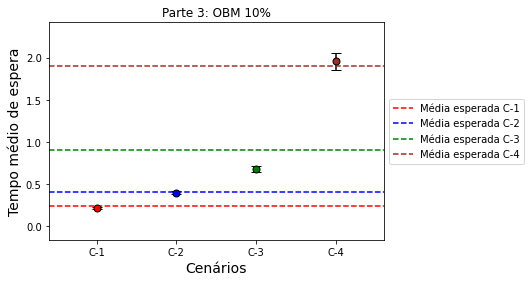

In [ ]:
valores_esperados = [c.fila.valor_esperado for c in nbm_cenarios]
plot_graph(resultados, valores_esperados, "Parte 3: OBM 10%")

### 25%

In [ ]:
N = 1000
cenarios = [
    Simulador_Fila(n=N, tx_entrada=7, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=8, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=9, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=9.5, tx_servico=10, gerador=va_exp),
]
for i, c in enumerate(cenarios):
    print(f"Cenário {i + 1}: Entrada {c.tx_entrada} Servico {c.tx_servico}")
    valido, ponto = mser_5y(fila=c, M=5)
    while not valido:
        if ponto == -1:
            print(f"MSER-5Y inválido: Valores iguais encontrados na primeira metade da série.")
        if ponto == -2:
            print(f"MSER-5Y inválido: Estatística menor na segunda metade da série.")
        tmp = c.n
        c.incrementar(c.n)
        print(f'Coletar mais {tmp} observações. Total (n) = {c.n}')
        valido, ponto = mser_5y(fila=c, M=5)
    print(f"MSER-5Y válido: ponto de truncagem={ponto}")
    c.eliminar_transiente(ponto)
    print()

N=1000 Gerando 1000 [0,999]: 100%|██████████| 1000/1000 [00:00<00:00, 334154.24it/s]


Cenário 1: Entrada 7 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 15443.51it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 2: Entrada 8 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 10599.44it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 3: Entrada 9 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 11454.84it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 4: Entrada 9.5 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 15280.91it/s]

MSER-5Y válido: ponto de truncagem=5



In [ ]:
M = 100  #Medias Inicial
B = 20  #Batch Inicial

# N = M*B -> Gerar observações até o necessário
obm_cenarios = [NBM(c, M, B) for c in cenarios]

N=2000 Gerando 1005 [995,1999]: 100%|██████████| 1005/1005 [00:00<00:00, 246593.86it/s]


In [ ]:
for i, cenario in enumerate(obm_cenarios):
    tentativa = 1
    while von_neuman(cenario) == False:
        print(f"Teste Von Neuman - Cenário {i + 1}, Tentativa {tentativa}-> N={cenario.fila.n}: Falha")
        cenario.incrementar(100)
        tentativa += 1
    print(f"\nTeste Von Neuman - Cenário {i + 1}, Tentativa {tentativa}-> N={cenario.fila.n}: Sucesso")


Teste Von Neuman - Cenário 1, Tentativa 1-> N=2000: Falha


N=4000 Gerando 2000 [2000,3999]: 100%|██████████| 2000/2000 [00:00<00:00, 152706.17it/s]


Teste Von Neuman - Cenário 1, Tentativa 2-> N=4000: Falha


N=6000 Gerando 2000 [4000,5999]: 100%|██████████| 2000/2000 [00:00<00:00, 166990.64it/s]


Teste Von Neuman - Cenário 1, Tentativa 3-> N=6000: Falha


N=8000 Gerando 2000 [6000,7999]: 100%|██████████| 2000/2000 [00:00<00:00, 146115.00it/s]


Teste Von Neuman - Cenário 1, Tentativa 4-> N=8000: Falha


N=10000 Gerando 2000 [8000,9999]: 100%|██████████| 2000/2000 [00:00<00:00, 311763.04it/s]


Teste Von Neuman - Cenário 1, Tentativa 5-> N=10000: Falha


N=12000 Gerando 2000 [10000,11999]: 100%|██████████| 2000/2000 [00:00<00:00, 432625.48it/s]


Teste Von Neuman - Cenário 1, Tentativa 6-> N=12000: Falha


N=14000 Gerando 2000 [12000,13999]: 100%|██████████| 2000/2000 [00:00<00:00, 154837.07it/s]


Teste Von Neuman - Cenário 1, Tentativa 7-> N=14000: Falha


N=16000 Gerando 2000 [14000,15999]: 100%|██████████| 2000/2000 [00:00<00:00, 287113.94it/s]


Teste Von Neuman - Cenário 1, Tentativa 8-> N=16000: Falha


N=18000 Gerando 2000 [16000,17999]: 100%|██████████| 2000/2000 [00:00<00:00, 407926.86it/s]


Teste Von Neuman - Cenário 1, Tentativa 9-> N=18000: Falha


N=20000 Gerando 2000 [18000,19999]: 100%|██████████| 2000/2000 [00:00<00:00, 241440.48it/s]


Teste Von Neuman - Cenário 1, Tentativa 10-> N=20000: Falha


N=22000 Gerando 2000 [20000,21999]: 100%|██████████| 2000/2000 [00:00<00:00, 238583.85it/s]


Teste Von Neuman - Cenário 1, Tentativa 11-> N=22000: Falha


N=24000 Gerando 2000 [22000,23999]: 100%|██████████| 2000/2000 [00:00<00:00, 276177.26it/s]


Teste Von Neuman - Cenário 1, Tentativa 12-> N=24000: Falha


N=26000 Gerando 2000 [24000,25999]: 100%|██████████| 2000/2000 [00:00<00:00, 237570.32it/s]


Teste Von Neuman - Cenário 1, Tentativa 13-> N=26000: Falha


N=28000 Gerando 2000 [26000,27999]: 100%|██████████| 2000/2000 [00:00<00:00, 259789.66it/s]



Teste Von Neuman - Cenário 1, Tentativa 14-> N=28000: Sucesso

Teste Von Neuman - Cenário 2, Tentativa 1-> N=2000: Sucesso

Teste Von Neuman - Cenário 3, Tentativa 1-> N=2000: Sucesso

Teste Von Neuman - Cenário 4, Tentativa 1-> N=2000: Sucesso


In [ ]:
resultados = []
for i, cenario in enumerate(nbm_cenarios):
    print(f'\nCenário {i + 1}\n')
    cenario.agrupamento_obm(overlap=0.25)
    media, H = cenario.metricas_obm()
    precisao_relativa = H / media
    while precisao_relativa > 0.05:
        cenario.fila.redimensionar(cenario.B_linha * cenario.M)
        cenario.agrupamento_obm(overlap=0.25)
        media, H = cenario.metricas_obm()
        precisao_relativa = H / media
    print(f'\nCenário {i + 1}: Media={media}, H={H}\n')
    resultados.append((media, H))


Cenário 1


Cenário 1: Media=0.22356998673498252, H=0.00820904693832632


Cenário 2



N=277500 Gerando 69000 [208500,277499]: 100%|██████████| 69000/69000 [00:00<00:00, 538371.49it/s]



Cenário 2: Media=0.3803979526207127, H=0.016038531080930358


Cenário 3



N=99800 Gerando 24900 [74900,99799]: 100%|██████████| 24900/24900 [00:00<00:00, 456452.55it/s]



Cenário 3: Media=0.8389037878357221, H=0.039681770062321986


Cenário 4



N=123100 Gerando 30700 [92400,123099]: 100%|██████████| 30700/30700 [00:00<00:00, 561763.28it/s]


Cenário 4: Media=1.990784472299269, H=0.08790264820858523



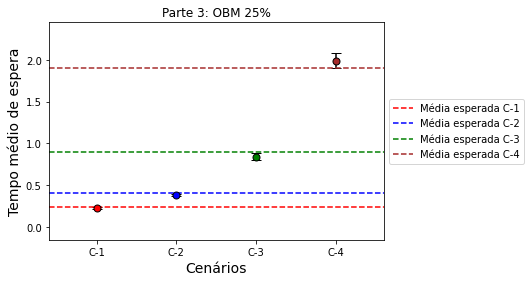

In [ ]:
valores_esperados = [c.fila.valor_esperado for c in obm_cenarios]
plot_graph(resultados, valores_esperados, "Parte 3: OBM 25%")

### 50%

In [ ]:
N = 1000
cenarios = [
    Simulador_Fila(n=N, tx_entrada=7, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=8, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=9, tx_servico=10, gerador=va_exp),
    Simulador_Fila(n=N, tx_entrada=9.5, tx_servico=10, gerador=va_exp),
]
for i, c in enumerate(cenarios):
    print(f"Cenário {i + 1}: Entrada {c.tx_entrada} Servico {c.tx_servico}")
    valido, ponto = mser_5y(fila=c, M=5)
    while not valido:
        if ponto == -1:
            print(f"MSER-5Y inválido: Valores iguais encontrados na primeira metade da série.")
        if ponto == -2:
            print(f"MSER-5Y inválido: Estatística menor na segunda metade da série.")
        tmp = c.n
        c.incrementar(c.n)
        print(f'Coletar mais {tmp} observações. Total (n) = {c.n}')
        valido, ponto = mser_5y(fila=c, M=5)
    print(f"MSER-5Y válido: ponto de truncagem={ponto}")
    c.eliminar_transiente(ponto)
    print()

N=1000 Gerando 1000 [0,999]: 100%|██████████| 1000/1000 [00:00<00:00, 585224.50it/s]


Cenário 1: Entrada 7 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 12868.33it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 2: Entrada 8 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 18697.03it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 3: Entrada 9 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 13291.20it/s]


MSER-5Y válido: ponto de truncagem=5

Cenário 4: Entrada 9.5 Servico 10


Validar MSER5Y-Segunda Metade: 100%|██████████| 100/100 [00:00<00:00, 10730.14it/s]

MSER-5Y válido: ponto de truncagem=35



In [ ]:
M = 100  #Medias Inicial
B = 20  #Batch Inicial

# N = M*B -> Gerar observações até o necessário
nbm_cenarios = [NBM(c, M, B) for c in cenarios]

N=2000 Gerando 1035 [965,1999]: 100%|██████████| 1035/1035 [00:00<00:00, 289832.06it/s]


In [ ]:
for i, cenario in enumerate(obm_cenarios):
    tentativa = 1
    while von_neuman(cenario) == False:
        print(f"Teste Von Neuman - Cenário {i + 1}, Tentativa {tentativa}-> N={cenario.fila.n}: Falha")
        cenario.incrementar(100)
        tentativa += 1
    print(f"\nTeste Von Neuman - Cenário {i + 1}, Tentativa {tentativa}-> N={cenario.fila.n}: Sucesso")



Teste Von Neuman - Cenário 1, Tentativa 1-> N=28000: Sucesso

Teste Von Neuman - Cenário 2, Tentativa 1-> N=2000: Sucesso

Teste Von Neuman - Cenário 3, Tentativa 1-> N=2000: Sucesso

Teste Von Neuman - Cenário 4, Tentativa 1-> N=2000: Sucesso


In [ ]:
resultados = []
for i, cenario in enumerate(nbm_cenarios):
    print(f'\nCenário {i + 1}\n')
    cenario.agrupamento_obm(overlap=0.50)
    media, H = cenario.metricas_obm()
    precisao_relativa = H / media
    while precisao_relativa > 0.05:
        cenario.fila.redimensionar(cenario.B_linha * cenario.M)
        cenario.agrupamento_obm(overlap=0.50)
        media, H = cenario.metricas_obm()
        precisao_relativa = H / media
    print(f'\nCenário {i + 1}: Media={media}, H={H}\n')
    resultados.append((media, H))


Cenário 1



N=30500 Gerando 15200 [15300,30499]: 100%|██████████| 15200/15200 [00:00<00:00, 488505.76it/s]



Cenário 1: Media=0.21999747405085113, H=0.010678788465360948


Cenário 2



N=60900 Gerando 30400 [30500,60899]: 100%|██████████| 30400/30400 [00:00<00:00, 555747.61it/s]



Cenário 2: Media=0.37456788876974184, H=0.01730649094971828


Cenário 3



N=121700 Gerando 60800 [60900,121699]: 100%|██████████| 60800/60800 [00:00<00:00, 526326.65it/s]



Cenário 3: Media=1.00074398587705, H=0.042176746350420485


Cenário 4



N=243300 Gerando 121600 [121700,243299]: 100%|██████████| 121600/121600 [00:00<00:00, 555639.84it/s]


Cenário 4: Media=2.242083050633792, H=0.07836916012367813



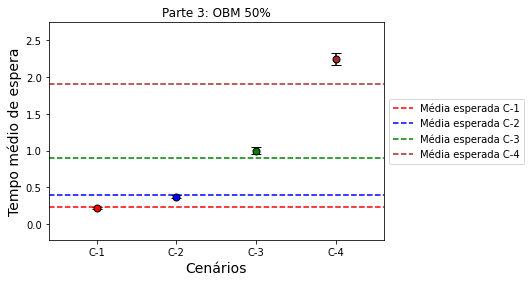

In [ ]:
valores_esperados = [c.fila.valor_esperado for c in obm_cenarios]
plot_graph(resultados, valores_esperados, "Parte 3: OBM 50%")

# Considerações Finais

Usando o Método NBM, o cenário C-3 não ficou próximo do valor esperado. Usando OBM o resultado para 25% de overlapping foi o melhor de todos, onde todos os resultados ficando em torno do valor da média esperada, além de ter um resultado mais rápido na execução do método.

O OBM para 10 e 50% falharam em um cenário e dois cenários, respectivamente. Vale ressaltar que o cenário de 10% também ficou em torno da média esperada no cenário mais difícil (C4).

Na parte 2, o uso do OBM com 100% overlapping não ficou bem implementado e os resultados não ficaram condizentes com o que deveria ser, refletindo no gráfico de resultados. A dificuldade foi alcançar o valor bom de precisão relativa que gerava loops muito grandes devido a grande quantidade de overlapping. Reduzir o tamanho do overlapping melhor infinitamente o resultado da implementação.

Portanto, o melhor método nesse experimento foi o OBM 25% em todos cenários.